<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [SYNOP2] - First predictions at 3h
<!-- DESC --> Episode 2 : Learning session and weather prediction attempt at 3h
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Make a simple prediction (3h)
 - Understanding the use of a recurrent neural network


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read our dataset
 - Select our data and normalize it
 - Doing our training
 - Making simple predictions

## Step 1 - Import and init
### 1.1 - Python

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('SYNOP2')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.18
Notebook id          : SYNOP2
Run time             : Sunday 07 March 2021, 21:16:03
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


### 1.2 - Parameters

In [2]:
# ---- About dataset
#
dataset_dir      = './data'
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- About training
#
scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 16
batch_size       = 32
epochs           = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('scale', 'train_prop', 'sequence_len', 'batch_size', 'epochs')

## Step 2 - Read and prepare dataset
### 2.1 - Read it

In [4]:
# ---- Read dataset from ./data

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# ---- Scaling

df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
pwk.subtitle('Train dataset example :')
display(dataset_train.head(15))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

pwk.subtitle('After normalization :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

pwk.subtitle('Shapes :')
print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)


<br>**Train dataset example :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
0,-120.0,6.0,0.0,0.0,278.75,88.0,60.0,96250.0,4.1,0.0,0.0,7.5
1,-150.0,6.0,60.0,1.0,278.65,93.0,61.0,96100.0,2.6,0.2,0.6,6.6
2,10.0,3.0,280.0,2.1,278.85,95.0,58.0,96110.0,2.6,0.0,0.4,6.4
3,230.0,3.0,310.0,2.6,279.15,96.0,50.0,96340.0,5.7,0.0,3.0,6.6
4,280.0,1.0,330.0,4.6,278.15,94.0,21.0,96620.0,8.7,0.4,0.8,5.9
5,480.0,3.0,350.0,5.1,276.95,91.0,60.0,97100.0,8.2,0.2,0.4,5.2
6,530.0,2.0,350.0,3.1,274.05,83.0,21.0,97630.0,7.2,0.0,0.0,3.5
7,450.0,2.0,340.0,6.2,272.15,81.0,2.0,98080.0,9.3,0.0,0.0,1.9
8,280.0,1.0,320.0,6.2,270.15,74.0,2.0,98360.0,10.3,0.0,0.0,1.1
9,220.0,1.0,290.0,2.6,269.65,72.0,2.0,98580.0,5.1,0.0,0.0,1.0


<br>**After normalization :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
count,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00
mean,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-6.79,-1.59,-1.74,-1.36,-5.22,-3.85,-0.53,-4.97,-1.62,-0.32,-0.27,-3.04
25%,-0.63,-0.85,-0.62,-0.75,-0.72,-0.68,-0.42,-0.55,-0.69,-0.16,-0.20,-0.75
50%,-0.00,-0.48,-0.11,-0.19,0.04,0.21,-0.42,0.04,-0.29,-0.16,-0.20,-0.01
75%,0.63,0.99,1.10,0.50,0.77,0.82,-0.37,0.62,0.51,-0.16,-0.20,0.71
max,7.14,1.36,1.35,6.24,2.44,1.59,4.45,3.08,6.25,29.82,31.17,3.07


<br>**Shapes :**

Dataset       :  (29165, 14)
Train dataset :  (23332, 12)
Test  dataset :  (5833, 12)


### 2.2 - Prepare data generator

In [5]:
# ---- Train generator
train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

pwk.subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
pwk.subtitle('What a batch looks like (x) :')
pwk.np_print(x[0] )
pwk.subtitle('What a batch looks like (y) :')
pwk.np_print(y[0])

<br>**About the splitting of our dataset :**

Nombre de train batchs disponibles :  729
batch x shape :  (32, 16, 12)
batch y shape :  (32, 12)


<br>**What a batch looks like (x) :**

[[-1.087  0.623 -1.743 -1.361 -0.212  0.928  2.554 -3.533 -0.555 -0.156 -0.199 -0.624]
 [-1.358  0.623 -1.227 -0.957 -0.229  1.206  2.605 -3.733 -0.946  0.17   0.219 -0.735]
 [ 0.089 -0.482  0.666 -0.512 -0.195  1.317  2.451 -3.72  -0.946 -0.156  0.08  -0.76 ]
 [ 2.079 -0.482  0.924 -0.31  -0.144  1.372  2.04  -3.413 -0.137 -0.156  1.892 -0.735]
 [ 2.531 -1.219  1.096  0.499 -0.313  1.261  0.552 -3.04   0.645  0.495  0.358 -0.821]
 [ 4.34  -0.482  1.268  0.701 -0.517  1.095  2.554 -2.401  0.515  0.17   0.08  -0.907]
 [ 4.792 -0.85   1.268 -0.107 -1.01   0.65   0.552 -1.694  0.254 -0.156 -0.199 -1.117]
 [ 4.069 -0.85   1.182  1.146 -1.333  0.539 -0.424 -1.094  0.802 -0.156 -0.199 -1.314]
 [ 2.531 -1.219  1.01   1.146 -1.673  0.15  -0.424 -0.721  1.063 -0.156 -0.199 -1.412]
 [ 1.988 -1.219  0.752 -0.31  -1.758  0.039 -0.424 -0.428 -0.294 -0.156 -0.199 -1.425]
 [ 0.903 -1.219  1.268 -0.107 -1.622  0.428 -0.424 -0.295 -0.555 -0.156 -0.199 -1.486]
 [ 2.712 -0.482  1.268  0.701 -1.944 -0.072

<br>**What a batch looks like (y) :**

[ 0.179 -1.219  0.58  -0.755 -2.063  0.65  -0.424  0.665 -1.233 -0.156 -0.199 -1.93 ]


## Step 3 - Create a model

In [6]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.LSTM(100, activation='relu') )
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               45200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 46,412
Trainable params: 46,412
Non-trainable params: 0
_________________________________________________________________


# Step 4 - Compile and run

### 4.1 - Callback

In [7]:
pwk.mkdir('./run/models')
save_dir = './run/models/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 4.2 - Compile

In [8]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

### 4.3 - Fit
6' with a CPU (laptop)  
2' with a GPU

In [9]:
pwk.chrono_start()

history=model.fit(train_generator, 
                  epochs=epochs, 
                  verbose=1,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

pwk.chrono_show()

Epoch 1/10


  1/729 [..............................] - ETA: 0s - loss: 0.7998 - mae: 0.7227

  4/729 [..............................] - ETA: 9s - loss: 0.8029 - mae: 0.6500

  7/729 [..............................] - ETA: 10s - loss: 0.8472 - mae: 0.6846

 11/729 [..............................] - ETA: 10s - loss: 1.0554 - mae: 0.7089

 15/729 [..............................] - ETA: 10s - loss: 1.1500 - mae: 0.7243

 19/729 [..............................] - ETA: 10s - loss: 1.1198 - mae: 0.7231

 23/729 [..............................] - ETA: 10s - loss: 1.0680 - mae: 0.7143

 27/729 [>.............................] - ETA: 10s - loss: 1.0398 - mae: 0.7143

 31/729 [>.............................] - ETA: 10s - loss: 1.0116 - mae: 0.7119

 35/729 [>.............................] - ETA: 10s - loss: 0.9665 - mae: 0.6979

 39/729 [>.............................] - ETA: 10s - loss: 0.9391 - mae: 0.6891

 43/729 [>.............................] - ETA: 10s - loss: 0.9188 - mae: 0.6822

 47/729 [>.............................] - ETA: 10s - loss: 0.9072 - mae: 0.6766

 51/729 [=>............................] - ETA: 10s - loss: 0.8839 - mae: 0.6696

 55/729 [=>............................] - ETA: 9s - loss: 0.8574 - mae: 0.6589 

 60/729 [=>............................] - ETA: 9s - loss: 0.8542 - mae: 0.6539

 64/729 [=>............................] - ETA: 9s - loss: 0.8286 - mae: 0.6441

 68/729 [=>............................] - ETA: 9s - loss: 0.8356 - mae: 0.6413

 72/729 [=>............................] - ETA: 9s - loss: 0.8383 - mae: 0.6386

 77/729 [==>...........................] - ETA: 9s - loss: 0.8205 - mae: 0.6326

 82/729 [==>...........................] - ETA: 9s - loss: 0.8110 - mae: 0.6289

 87/729 [==>...........................] - ETA: 8s - loss: 0.7991 - mae: 0.6260

 92/729 [==>...........................] - ETA: 8s - loss: 0.7875 - mae: 0.6214

 97/729 [==>...........................] - ETA: 8s - loss: 0.7775 - mae: 0.6179

102/729 [===>..........................] - ETA: 8s - loss: 0.8083 - mae: 0.6139

107/729 [===>..........................] - ETA: 8s - loss: 0.8059 - mae: 0.6131

112/729 [===>..........................] - ETA: 8s - loss: 0.8065 - mae: 0.6131

117/729 [===>..........................] - ETA: 8s - loss: 0.8056 - mae: 0.6124

122/729 [====>.........................] - ETA: 8s - loss: 0.7986 - mae: 0.6110

127/729 [====>.........................] - ETA: 8s - loss: 0.7878 - mae: 0.6072

132/729 [====>.........................] - ETA: 7s - loss: 0.7781 - mae: 0.6037

137/729 [====>.........................] - ETA: 7s - loss: 0.7737 - mae: 0.6025

142/729 [====>.........................] - ETA: 7s - loss: 0.7690 - mae: 0.6005

147/729 [=====>........................] - ETA: 7s - loss: 0.7703 - mae: 0.5986

152/729 [=====>........................] - ETA: 7s - loss: 0.7671 - mae: 0.5982

156/729 [=====>........................] - ETA: 7s - loss: 0.7650 - mae: 0.5978

161/729 [=====>........................] - ETA: 7s - loss: 0.7563 - mae: 0.5950

166/729 [=====>........................] - ETA: 7s - loss: 0.7517 - mae: 0.5935

171/729 [======>.......................] - ETA: 7s - loss: 0.7587 - mae: 0.5954

176/729 [======>.......................] - ETA: 7s - loss: 0.7680 - mae: 0.5947

181/729 [======>.......................] - ETA: 7s - loss: 0.7653 - mae: 0.5947

186/729 [======>.......................] - ETA: 7s - loss: 0.7627 - mae: 0.5941

191/729 [======>.......................] - ETA: 6s - loss: 0.7553 - mae: 0.5920

196/729 [=======>......................] - ETA: 6s - loss: 0.7499 - mae: 0.5894

201/729 [=======>......................] - ETA: 6s - loss: 0.7425 - mae: 0.5867

206/729 [=======>......................] - ETA: 6s - loss: 0.7377 - mae: 0.5852

211/729 [=======>......................] - ETA: 6s - loss: 0.7319 - mae: 0.5824

216/729 [=======>......................] - ETA: 6s - loss: 0.7291 - mae: 0.5805

221/729 [========>.....................] - ETA: 6s - loss: 0.7251 - mae: 0.5794

226/729 [========>.....................] - ETA: 6s - loss: 0.7183 - mae: 0.5767

231/729 [========>.....................] - ETA: 6s - loss: 0.7165 - mae: 0.5763

236/729 [========>.....................] - ETA: 6s - loss: 0.7118 - mae: 0.5748

241/729 [========>.....................] - ETA: 6s - loss: 0.7072 - mae: 0.5732

246/729 [=========>....................] - ETA: 6s - loss: 0.7022 - mae: 0.5713

251/729 [=========>....................] - ETA: 6s - loss: 0.6989 - mae: 0.5694

256/729 [=========>....................] - ETA: 6s - loss: 0.6995 - mae: 0.5687

260/729 [=========>....................] - ETA: 5s - loss: 0.6954 - mae: 0.5673

265/729 [=========>....................] - ETA: 5s - loss: 0.6952 - mae: 0.5668

269/729 [==========>...................] - ETA: 5s - loss: 0.6932 - mae: 0.5661

273/729 [==========>...................] - ETA: 5s - loss: 0.6963 - mae: 0.5662

277/729 [==========>...................] - ETA: 5s - loss: 0.6943 - mae: 0.5658

281/729 [==========>...................] - ETA: 5s - loss: 0.6918 - mae: 0.5650

285/729 [==========>...................] - ETA: 5s - loss: 0.6901 - mae: 0.5643

289/729 [==========>...................] - ETA: 5s - loss: 0.6899 - mae: 0.5642

293/729 [===========>..................] - ETA: 5s - loss: 0.6867 - mae: 0.5630

297/729 [===========>..................] - ETA: 5s - loss: 0.6894 - mae: 0.5634

301/729 [===========>..................] - ETA: 5s - loss: 0.6962 - mae: 0.5627

305/729 [===========>..................] - ETA: 5s - loss: 0.6944 - mae: 0.5618

309/729 [===========>..................] - ETA: 5s - loss: 0.6922 - mae: 0.5612

313/729 [===========>..................] - ETA: 5s - loss: 0.6922 - mae: 0.5606

317/729 [============>.................] - ETA: 5s - loss: 0.6884 - mae: 0.5592

321/729 [============>.................] - ETA: 5s - loss: 0.6882 - mae: 0.5584

325/729 [============>.................] - ETA: 5s - loss: 0.6860 - mae: 0.5575

329/729 [============>.................] - ETA: 5s - loss: 0.6852 - mae: 0.5574

333/729 [============>.................] - ETA: 5s - loss: 0.6941 - mae: 0.5579

337/729 [============>.................] - ETA: 5s - loss: 0.6913 - mae: 0.5570

341/729 [=============>................] - ETA: 5s - loss: 0.6885 - mae: 0.5560

345/729 [=============>................] - ETA: 4s - loss: 0.6855 - mae: 0.5550

349/729 [=============>................] - ETA: 4s - loss: 0.6827 - mae: 0.5541

353/729 [=============>................] - ETA: 4s - loss: 0.6867 - mae: 0.5543

357/729 [=============>................] - ETA: 4s - loss: 0.6874 - mae: 0.5544

361/729 [=============>................] - ETA: 4s - loss: 0.6845 - mae: 0.5535

365/729 [==============>...............] - ETA: 4s - loss: 0.6815 - mae: 0.5523

369/729 [==============>...............] - ETA: 4s - loss: 0.6790 - mae: 0.5513

373/729 [==============>...............] - ETA: 4s - loss: 0.6766 - mae: 0.5503

377/729 [==============>...............] - ETA: 4s - loss: 0.6753 - mae: 0.5498

381/729 [==============>...............] - ETA: 4s - loss: 0.6762 - mae: 0.5495

385/729 [==============>...............] - ETA: 4s - loss: 0.6737 - mae: 0.5487

389/729 [===============>..............] - ETA: 4s - loss: 0.6776 - mae: 0.5486

393/729 [===============>..............] - ETA: 4s - loss: 0.6751 - mae: 0.5477

397/729 [===============>..............] - ETA: 4s - loss: 0.6729 - mae: 0.5469

401/729 [===============>..............] - ETA: 4s - loss: 0.6719 - mae: 0.5465

405/729 [===============>..............] - ETA: 4s - loss: 0.6703 - mae: 0.5458

409/729 [===============>..............] - ETA: 4s - loss: 0.6677 - mae: 0.5450

413/729 [===============>..............] - ETA: 4s - loss: 0.6718 - mae: 0.5451

417/729 [================>.............] - ETA: 4s - loss: 0.6701 - mae: 0.5446

421/729 [================>.............] - ETA: 4s - loss: 0.6675 - mae: 0.5436

425/729 [================>.............] - ETA: 4s - loss: 0.6648 - mae: 0.5428

429/729 [================>.............] - ETA: 3s - loss: 0.6635 - mae: 0.5424

433/729 [================>.............] - ETA: 3s - loss: 0.6631 - mae: 0.5421

437/729 [================>.............] - ETA: 3s - loss: 0.6609 - mae: 0.5413

441/729 [=================>............] - ETA: 3s - loss: 0.6586 - mae: 0.5403

445/729 [=================>............] - ETA: 3s - loss: 0.6569 - mae: 0.5398

449/729 [=================>............] - ETA: 3s - loss: 0.6564 - mae: 0.5394

453/729 [=================>............] - ETA: 3s - loss: 0.6543 - mae: 0.5387

457/729 [=================>............] - ETA: 3s - loss: 0.6521 - mae: 0.5380

461/729 [=================>............] - ETA: 3s - loss: 0.6511 - mae: 0.5375

465/729 [==================>...........] - ETA: 3s - loss: 0.6499 - mae: 0.5371

469/729 [==================>...........] - ETA: 3s - loss: 0.6486 - mae: 0.5364

473/729 [==================>...........] - ETA: 3s - loss: 0.6478 - mae: 0.5362

477/729 [==================>...........] - ETA: 3s - loss: 0.6465 - mae: 0.5357

481/729 [==================>...........] - ETA: 3s - loss: 0.6454 - mae: 0.5351

485/729 [==================>...........] - ETA: 3s - loss: 0.6441 - mae: 0.5344

489/729 [===================>..........] - ETA: 3s - loss: 0.6439 - mae: 0.5340

493/729 [===================>..........] - ETA: 3s - loss: 0.6442 - mae: 0.5337

497/729 [===================>..........] - ETA: 3s - loss: 0.6436 - mae: 0.5333

501/729 [===================>..........] - ETA: 3s - loss: 0.6418 - mae: 0.5327

505/729 [===================>..........] - ETA: 2s - loss: 0.6397 - mae: 0.5319

509/729 [===================>..........] - ETA: 2s - loss: 0.6421 - mae: 0.5318

513/729 [====================>.........] - ETA: 2s - loss: 0.6421 - mae: 0.5314

517/729 [====================>.........] - ETA: 2s - loss: 0.6407 - mae: 0.5310

521/729 [====================>.........] - ETA: 2s - loss: 0.6397 - mae: 0.5305

525/729 [====================>.........] - ETA: 2s - loss: 0.6387 - mae: 0.5303

529/729 [====================>.........] - ETA: 2s - loss: 0.6410 - mae: 0.5301

533/729 [====================>.........] - ETA: 2s - loss: 0.6398 - mae: 0.5298

537/729 [=====================>........] - ETA: 2s - loss: 0.6387 - mae: 0.5294

541/729 [=====================>........] - ETA: 2s - loss: 0.6372 - mae: 0.5289

545/729 [=====================>........] - ETA: 2s - loss: 0.6354 - mae: 0.5282

549/729 [=====================>........] - ETA: 2s - loss: 0.6350 - mae: 0.5281

553/729 [=====================>........] - ETA: 2s - loss: 0.6337 - mae: 0.5277

557/729 [=====================>........] - ETA: 2s - loss: 0.6361 - mae: 0.5276

561/729 [======================>.......] - ETA: 2s - loss: 0.6356 - mae: 0.5275

565/729 [======================>.......] - ETA: 2s - loss: 0.6344 - mae: 0.5270

569/729 [======================>.......] - ETA: 2s - loss: 0.6368 - mae: 0.5270

573/729 [======================>.......] - ETA: 2s - loss: 0.6364 - mae: 0.5269

577/729 [======================>.......] - ETA: 2s - loss: 0.6355 - mae: 0.5265

581/729 [======================>.......] - ETA: 1s - loss: 0.6370 - mae: 0.5267

585/729 [=======================>......] - ETA: 1s - loss: 0.6349 - mae: 0.5259

589/729 [=======================>......] - ETA: 1s - loss: 0.6334 - mae: 0.5253

593/729 [=======================>......] - ETA: 1s - loss: 0.6329 - mae: 0.5252

597/729 [=======================>......] - ETA: 1s - loss: 0.6321 - mae: 0.5248

601/729 [=======================>......] - ETA: 1s - loss: 0.6304 - mae: 0.5242

605/729 [=======================>......] - ETA: 1s - loss: 0.6293 - mae: 0.5239

609/729 [========================>.....] - ETA: 1s - loss: 0.6281 - mae: 0.5235

613/729 [========================>.....] - ETA: 1s - loss: 0.6275 - mae: 0.5231

617/729 [========================>.....] - ETA: 1s - loss: 0.6260 - mae: 0.5225

621/729 [========================>.....] - ETA: 1s - loss: 0.6267 - mae: 0.5223

625/729 [========================>.....] - ETA: 1s - loss: 0.6257 - mae: 0.5219

629/729 [========================>.....] - ETA: 1s - loss: 0.6248 - mae: 0.5214

633/729 [=========================>....] - ETA: 1s - loss: 0.6240 - mae: 0.5211

637/729 [=========================>....] - ETA: 1s - loss: 0.6275 - mae: 0.5211

641/729 [=========================>....] - ETA: 1s - loss: 0.6263 - mae: 0.5206

645/729 [=========================>....] - ETA: 1s - loss: 0.6254 - mae: 0.5202

649/729 [=========================>....] - ETA: 1s - loss: 0.6240 - mae: 0.5197

653/729 [=========================>....] - ETA: 1s - loss: 0.6231 - mae: 0.5195

657/729 [==========================>...] - ETA: 0s - loss: 0.6220 - mae: 0.5191

661/729 [==========================>...] - ETA: 0s - loss: 0.6212 - mae: 0.5190

665/729 [==========================>...] - ETA: 0s - loss: 0.6210 - mae: 0.5188

669/729 [==========================>...] - ETA: 0s - loss: 0.6209 - mae: 0.5187

673/729 [==========================>...] - ETA: 0s - loss: 0.6199 - mae: 0.5183

677/729 [==========================>...] - ETA: 0s - loss: 0.6184 - mae: 0.5178

681/729 [===========================>..] - ETA: 0s - loss: 0.6174 - mae: 0.5175

685/729 [===========================>..] - ETA: 0s - loss: 0.6174 - mae: 0.5172

689/729 [===========================>..] - ETA: 0s - loss: 0.6165 - mae: 0.5168

693/729 [===========================>..] - ETA: 0s - loss: 0.6150 - mae: 0.5163

697/729 [===========================>..] - ETA: 0s - loss: 0.6144 - mae: 0.5161

701/729 [===========================>..] - ETA: 0s - loss: 0.6151 - mae: 0.5162

705/729 [============================>.] - ETA: 0s - loss: 0.6137 - mae: 0.5157

709/729 [============================>.] - ETA: 0s - loss: 0.6125 - mae: 0.5153

713/729 [============================>.] - ETA: 0s - loss: 0.6117 - mae: 0.5150

717/729 [============================>.] - ETA: 0s - loss: 0.6152 - mae: 0.5147

721/729 [============================>.] - ETA: 0s - loss: 0.6168 - mae: 0.5148

725/729 [============================>.] - ETA: 0s - loss: 0.6160 - mae: 0.5146

729/729 [==============================] - ETA: 0s - loss: 0.6152 - mae: 0.5144

729/729 [==============================] - 11s 15ms/step - loss: 0.6152 - mae: 0.5144 - val_loss: 0.4935 - val_mae: 0.4329


Epoch 2/10
  1/729 [..............................] - ETA: 0s - loss: 0.5714 - mae: 0.5356

  5/729 [..............................] - ETA: 8s - loss: 0.6197 - mae: 0.5102

  9/729 [..............................] - ETA: 9s - loss: 0.5084 - mae: 0.4746

 13/729 [..............................] - ETA: 9s - loss: 0.4564 - mae: 0.4545

 17/729 [..............................] - ETA: 9s - loss: 0.4512 - mae: 0.4521

 21/729 [..............................] - ETA: 9s - loss: 0.4350 - mae: 0.4444

 25/729 [>.............................] - ETA: 9s - loss: 0.4412 - mae: 0.4472

 29/729 [>.............................] - ETA: 9s - loss: 0.4286 - mae: 0.4422

 33/729 [>.............................] - ETA: 9s - loss: 0.4459 - mae: 0.4453

 37/729 [>.............................] - ETA: 9s - loss: 0.4419 - mae: 0.4464

 41/729 [>.............................] - ETA: 9s - loss: 0.4732 - mae: 0.4476

 45/729 [>.............................] - ETA: 9s - loss: 0.4644 - mae: 0.4460

 49/729 [=>............................] - ETA: 9s - loss: 0.4664 - mae: 0.4480

 53/729 [=>............................] - ETA: 9s - loss: 0.4884 - mae: 0.4511

 57/729 [=>............................] - ETA: 9s - loss: 0.4904 - mae: 0.4512

 61/729 [=>............................] - ETA: 9s - loss: 0.5238 - mae: 0.4534

 65/729 [=>............................] - ETA: 9s - loss: 0.5220 - mae: 0.4527

 69/729 [=>............................] - ETA: 9s - loss: 0.5184 - mae: 0.4543

 73/729 [==>...........................] - ETA: 9s - loss: 0.5085 - mae: 0.4516

 77/729 [==>...........................] - ETA: 9s - loss: 0.5058 - mae: 0.4526

 81/729 [==>...........................] - ETA: 9s - loss: 0.5059 - mae: 0.4534

 85/729 [==>...........................] - ETA: 8s - loss: 0.5048 - mae: 0.4543

 89/729 [==>...........................] - ETA: 8s - loss: 0.5388 - mae: 0.4564

 93/729 [==>...........................] - ETA: 8s - loss: 0.5322 - mae: 0.4545

 97/729 [==>...........................] - ETA: 8s - loss: 0.5273 - mae: 0.4545

101/729 [===>..........................] - ETA: 8s - loss: 0.5356 - mae: 0.4548

105/729 [===>..........................] - ETA: 8s - loss: 0.5393 - mae: 0.4559

109/729 [===>..........................] - ETA: 8s - loss: 0.5415 - mae: 0.4561

113/729 [===>..........................] - ETA: 8s - loss: 0.5514 - mae: 0.4566

117/729 [===>..........................] - ETA: 8s - loss: 0.5625 - mae: 0.4597

121/729 [===>..........................] - ETA: 8s - loss: 0.5785 - mae: 0.4613

125/729 [====>.........................] - ETA: 8s - loss: 0.5708 - mae: 0.4597

129/729 [====>.........................] - ETA: 8s - loss: 0.5642 - mae: 0.4585

133/729 [====>.........................] - ETA: 8s - loss: 0.5621 - mae: 0.4594

137/729 [====>.........................] - ETA: 8s - loss: 0.5582 - mae: 0.4590

141/729 [====>.........................] - ETA: 8s - loss: 0.5571 - mae: 0.4592

145/729 [====>.........................] - ETA: 8s - loss: 0.5561 - mae: 0.4595

149/729 [=====>........................] - ETA: 8s - loss: 0.5511 - mae: 0.4582

153/729 [=====>........................] - ETA: 8s - loss: 0.5474 - mae: 0.4574

157/729 [=====>........................] - ETA: 7s - loss: 0.5443 - mae: 0.4570

161/729 [=====>........................] - ETA: 7s - loss: 0.5424 - mae: 0.4564

165/729 [=====>........................] - ETA: 7s - loss: 0.5412 - mae: 0.4568

169/729 [=====>........................] - ETA: 7s - loss: 0.5383 - mae: 0.4566

173/729 [======>.......................] - ETA: 7s - loss: 0.5363 - mae: 0.4567

177/729 [======>.......................] - ETA: 7s - loss: 0.5493 - mae: 0.4586

181/729 [======>.......................] - ETA: 7s - loss: 0.5444 - mae: 0.4574

185/729 [======>.......................] - ETA: 7s - loss: 0.5410 - mae: 0.4565

189/729 [======>.......................] - ETA: 7s - loss: 0.5374 - mae: 0.4561

193/729 [======>.......................] - ETA: 7s - loss: 0.5351 - mae: 0.4556

197/729 [=======>......................] - ETA: 7s - loss: 0.5319 - mae: 0.4548

201/729 [=======>......................] - ETA: 7s - loss: 0.5318 - mae: 0.4550

205/729 [=======>......................] - ETA: 7s - loss: 0.5306 - mae: 0.4555

209/729 [=======>......................] - ETA: 7s - loss: 0.5264 - mae: 0.4542

213/729 [=======>......................] - ETA: 7s - loss: 0.5331 - mae: 0.4537

217/729 [=======>......................] - ETA: 7s - loss: 0.5299 - mae: 0.4529

221/729 [========>.....................] - ETA: 7s - loss: 0.5293 - mae: 0.4525

225/729 [========>.....................] - ETA: 7s - loss: 0.5290 - mae: 0.4524

229/729 [========>.....................] - ETA: 7s - loss: 0.5293 - mae: 0.4530

233/729 [========>.....................] - ETA: 6s - loss: 0.5277 - mae: 0.4529

237/729 [========>.....................] - ETA: 6s - loss: 0.5261 - mae: 0.4526

241/729 [========>.....................] - ETA: 6s - loss: 0.5246 - mae: 0.4520

245/729 [=========>....................] - ETA: 6s - loss: 0.5224 - mae: 0.4518

249/729 [=========>....................] - ETA: 6s - loss: 0.5199 - mae: 0.4509

253/729 [=========>....................] - ETA: 6s - loss: 0.5191 - mae: 0.4502

257/729 [=========>....................] - ETA: 6s - loss: 0.5178 - mae: 0.4499

261/729 [=========>....................] - ETA: 6s - loss: 0.5178 - mae: 0.4499

265/729 [=========>....................] - ETA: 6s - loss: 0.5152 - mae: 0.4489

269/729 [==========>...................] - ETA: 6s - loss: 0.5175 - mae: 0.4492

273/729 [==========>...................] - ETA: 6s - loss: 0.5171 - mae: 0.4495

277/729 [==========>...................] - ETA: 6s - loss: 0.5169 - mae: 0.4496

281/729 [==========>...................] - ETA: 6s - loss: 0.5155 - mae: 0.4492

285/729 [==========>...................] - ETA: 6s - loss: 0.5129 - mae: 0.4483

289/729 [==========>...................] - ETA: 6s - loss: 0.5111 - mae: 0.4480

293/729 [===========>..................] - ETA: 6s - loss: 0.5178 - mae: 0.4494

297/729 [===========>..................] - ETA: 6s - loss: 0.5167 - mae: 0.4492

301/729 [===========>..................] - ETA: 6s - loss: 0.5180 - mae: 0.4501

305/729 [===========>..................] - ETA: 5s - loss: 0.5165 - mae: 0.4499

309/729 [===========>..................] - ETA: 5s - loss: 0.5161 - mae: 0.4501

313/729 [===========>..................] - ETA: 5s - loss: 0.5159 - mae: 0.4502

317/729 [============>.................] - ETA: 5s - loss: 0.5145 - mae: 0.4499

321/729 [============>.................] - ETA: 5s - loss: 0.5152 - mae: 0.4495

325/729 [============>.................] - ETA: 5s - loss: 0.5143 - mae: 0.4496

329/729 [============>.................] - ETA: 5s - loss: 0.5190 - mae: 0.4508

333/729 [============>.................] - ETA: 5s - loss: 0.5175 - mae: 0.4504

337/729 [============>.................] - ETA: 5s - loss: 0.5163 - mae: 0.4502

341/729 [=============>................] - ETA: 5s - loss: 0.5144 - mae: 0.4497

345/729 [=============>................] - ETA: 5s - loss: 0.5128 - mae: 0.4492

349/729 [=============>................] - ETA: 5s - loss: 0.5126 - mae: 0.4489

353/729 [=============>................] - ETA: 5s - loss: 0.5188 - mae: 0.4497

357/729 [=============>................] - ETA: 5s - loss: 0.5165 - mae: 0.4490

361/729 [=============>................] - ETA: 5s - loss: 0.5161 - mae: 0.4492

365/729 [==============>...............] - ETA: 5s - loss: 0.5155 - mae: 0.4493

369/729 [==============>...............] - ETA: 5s - loss: 0.5143 - mae: 0.4491

373/729 [==============>...............] - ETA: 5s - loss: 0.5134 - mae: 0.4490

377/729 [==============>...............] - ETA: 4s - loss: 0.5127 - mae: 0.4489

381/729 [==============>...............] - ETA: 4s - loss: 0.5114 - mae: 0.4486

385/729 [==============>...............] - ETA: 4s - loss: 0.5116 - mae: 0.4486

389/729 [===============>..............] - ETA: 4s - loss: 0.5105 - mae: 0.4483

393/729 [===============>..............] - ETA: 4s - loss: 0.5084 - mae: 0.4477

397/729 [===============>..............] - ETA: 4s - loss: 0.5075 - mae: 0.4475

401/729 [===============>..............] - ETA: 4s - loss: 0.5066 - mae: 0.4475

405/729 [===============>..............] - ETA: 4s - loss: 0.5049 - mae: 0.4470

409/729 [===============>..............] - ETA: 4s - loss: 0.5045 - mae: 0.4470

413/729 [===============>..............] - ETA: 4s - loss: 0.5029 - mae: 0.4465

417/729 [================>.............] - ETA: 4s - loss: 0.5011 - mae: 0.4460

421/729 [================>.............] - ETA: 4s - loss: 0.5012 - mae: 0.4461

425/729 [================>.............] - ETA: 4s - loss: 0.5000 - mae: 0.4458

429/729 [================>.............] - ETA: 4s - loss: 0.5005 - mae: 0.4462

433/729 [================>.............] - ETA: 4s - loss: 0.5085 - mae: 0.4464

437/729 [================>.............] - ETA: 4s - loss: 0.5093 - mae: 0.4470

441/729 [=================>............] - ETA: 4s - loss: 0.5087 - mae: 0.4467

445/729 [=================>............] - ETA: 3s - loss: 0.5076 - mae: 0.4466

449/729 [=================>............] - ETA: 3s - loss: 0.5088 - mae: 0.4469

453/729 [=================>............] - ETA: 3s - loss: 0.5089 - mae: 0.4469

457/729 [=================>............] - ETA: 3s - loss: 0.5090 - mae: 0.4470

461/729 [=================>............] - ETA: 3s - loss: 0.5088 - mae: 0.4468

465/729 [==================>...........] - ETA: 3s - loss: 0.5074 - mae: 0.4464

469/729 [==================>...........] - ETA: 3s - loss: 0.5100 - mae: 0.4471

473/729 [==================>...........] - ETA: 3s - loss: 0.5087 - mae: 0.4467

477/729 [==================>...........] - ETA: 3s - loss: 0.5089 - mae: 0.4468

481/729 [==================>...........] - ETA: 3s - loss: 0.5103 - mae: 0.4470

485/729 [==================>...........] - ETA: 3s - loss: 0.5089 - mae: 0.4467

489/729 [===================>..........] - ETA: 3s - loss: 0.5089 - mae: 0.4466

493/729 [===================>..........] - ETA: 3s - loss: 0.5084 - mae: 0.4466

497/729 [===================>..........] - ETA: 3s - loss: 0.5069 - mae: 0.4461

501/729 [===================>..........] - ETA: 3s - loss: 0.5060 - mae: 0.4460

505/729 [===================>..........] - ETA: 3s - loss: 0.5057 - mae: 0.4459

509/729 [===================>..........] - ETA: 3s - loss: 0.5117 - mae: 0.4463

513/729 [====================>.........] - ETA: 3s - loss: 0.5106 - mae: 0.4459

517/729 [====================>.........] - ETA: 2s - loss: 0.5095 - mae: 0.4456

521/729 [====================>.........] - ETA: 2s - loss: 0.5076 - mae: 0.4449

525/729 [====================>.........] - ETA: 2s - loss: 0.5062 - mae: 0.4444

529/729 [====================>.........] - ETA: 2s - loss: 0.5053 - mae: 0.4441

533/729 [====================>.........] - ETA: 2s - loss: 0.5040 - mae: 0.4438

537/729 [=====================>........] - ETA: 2s - loss: 0.5029 - mae: 0.4436

541/729 [=====================>........] - ETA: 2s - loss: 0.5042 - mae: 0.4438

545/729 [=====================>........] - ETA: 2s - loss: 0.5031 - mae: 0.4435

549/729 [=====================>........] - ETA: 2s - loss: 0.5023 - mae: 0.4432

553/729 [=====================>........] - ETA: 2s - loss: 0.5062 - mae: 0.4430

557/729 [=====================>........] - ETA: 2s - loss: 0.5056 - mae: 0.4429

561/729 [======================>.......] - ETA: 2s - loss: 0.5052 - mae: 0.4428

565/729 [======================>.......] - ETA: 2s - loss: 0.5047 - mae: 0.4426

569/729 [======================>.......] - ETA: 2s - loss: 0.5051 - mae: 0.4429

573/729 [======================>.......] - ETA: 2s - loss: 0.5051 - mae: 0.4429

577/729 [======================>.......] - ETA: 2s - loss: 0.5067 - mae: 0.4430

581/729 [======================>.......] - ETA: 2s - loss: 0.5058 - mae: 0.4428

585/729 [=======================>......] - ETA: 2s - loss: 0.5050 - mae: 0.4425

589/729 [=======================>......] - ETA: 1s - loss: 0.5038 - mae: 0.4421

593/729 [=======================>......] - ETA: 1s - loss: 0.5033 - mae: 0.4420

597/729 [=======================>......] - ETA: 1s - loss: 0.5031 - mae: 0.4419

601/729 [=======================>......] - ETA: 1s - loss: 0.5038 - mae: 0.4421

605/729 [=======================>......] - ETA: 1s - loss: 0.5034 - mae: 0.4420

609/729 [========================>.....] - ETA: 1s - loss: 0.5073 - mae: 0.4421

613/729 [========================>.....] - ETA: 1s - loss: 0.5073 - mae: 0.4421

617/729 [========================>.....] - ETA: 1s - loss: 0.5060 - mae: 0.4417

621/729 [========================>.....] - ETA: 1s - loss: 0.5051 - mae: 0.4415

625/729 [========================>.....] - ETA: 1s - loss: 0.5035 - mae: 0.4410

629/729 [========================>.....] - ETA: 1s - loss: 0.5028 - mae: 0.4408

633/729 [=========================>....] - ETA: 1s - loss: 0.5026 - mae: 0.4408

637/729 [=========================>....] - ETA: 1s - loss: 0.5021 - mae: 0.4406

641/729 [=========================>....] - ETA: 1s - loss: 0.5017 - mae: 0.4406

645/729 [=========================>....] - ETA: 1s - loss: 0.5027 - mae: 0.4407

649/729 [=========================>....] - ETA: 1s - loss: 0.5022 - mae: 0.4406

653/729 [=========================>....] - ETA: 1s - loss: 0.5037 - mae: 0.4408

657/729 [==========================>...] - ETA: 1s - loss: 0.5045 - mae: 0.4411

661/729 [==========================>...] - ETA: 0s - loss: 0.5044 - mae: 0.4410

665/729 [==========================>...] - ETA: 0s - loss: 0.5071 - mae: 0.4415

669/729 [==========================>...] - ETA: 0s - loss: 0.5060 - mae: 0.4412

673/729 [==========================>...] - ETA: 0s - loss: 0.5055 - mae: 0.4413

677/729 [==========================>...] - ETA: 0s - loss: 0.5056 - mae: 0.4415

681/729 [===========================>..] - ETA: 0s - loss: 0.5051 - mae: 0.4414

685/729 [===========================>..] - ETA: 0s - loss: 0.5073 - mae: 0.4416

689/729 [===========================>..] - ETA: 0s - loss: 0.5066 - mae: 0.4413

693/729 [===========================>..] - ETA: 0s - loss: 0.5055 - mae: 0.4410

697/729 [===========================>..] - ETA: 0s - loss: 0.5048 - mae: 0.4408

701/729 [===========================>..] - ETA: 0s - loss: 0.5046 - mae: 0.4408

705/729 [============================>.] - ETA: 0s - loss: 0.5038 - mae: 0.4406

709/729 [============================>.] - ETA: 0s - loss: 0.5046 - mae: 0.4409

713/729 [============================>.] - ETA: 0s - loss: 0.5039 - mae: 0.4408

717/729 [============================>.] - ETA: 0s - loss: 0.5040 - mae: 0.4409

721/729 [============================>.] - ETA: 0s - loss: 0.5035 - mae: 0.4409

725/729 [============================>.] - ETA: 0s - loss: 0.5066 - mae: 0.4413

729/729 [==============================] - ETA: 0s - loss: 0.5064 - mae: 0.4412

729/729 [==============================] - 11s 15ms/step - loss: 0.5064 - mae: 0.4412 - val_loss: 0.4618 - val_mae: 0.4092


Epoch 3/10
  1/729 [..............................] - ETA: 0s - loss: 0.3005 - mae: 0.3752

  5/729 [..............................] - ETA: 7s - loss: 0.3743 - mae: 0.4228

  9/729 [..............................] - ETA: 8s - loss: 0.3697 - mae: 0.4135

 13/729 [..............................] - ETA: 8s - loss: 0.4249 - mae: 0.4289

 17/729 [..............................] - ETA: 8s - loss: 0.4300 - mae: 0.4244

 21/729 [..............................] - ETA: 9s - loss: 0.5392 - mae: 0.4288

 25/729 [>.............................] - ETA: 9s - loss: 0.5310 - mae: 0.4320

 29/729 [>.............................] - ETA: 9s - loss: 0.5189 - mae: 0.4319

 33/729 [>.............................] - ETA: 9s - loss: 0.4904 - mae: 0.4225

 37/729 [>.............................] - ETA: 9s - loss: 0.4704 - mae: 0.4178

 41/729 [>.............................] - ETA: 9s - loss: 0.4552 - mae: 0.4145

 45/729 [>.............................] - ETA: 9s - loss: 0.4412 - mae: 0.4108

 49/729 [=>............................] - ETA: 9s - loss: 0.4418 - mae: 0.4123

 53/729 [=>............................] - ETA: 9s - loss: 0.4666 - mae: 0.4165

 57/729 [=>............................] - ETA: 9s - loss: 0.4616 - mae: 0.4154

 61/729 [=>............................] - ETA: 9s - loss: 0.4592 - mae: 0.4165

 65/729 [=>............................] - ETA: 9s - loss: 0.4582 - mae: 0.4154

 69/729 [=>............................] - ETA: 9s - loss: 0.4581 - mae: 0.4161

 73/729 [==>...........................] - ETA: 8s - loss: 0.4502 - mae: 0.4138

 77/729 [==>...........................] - ETA: 8s - loss: 0.4635 - mae: 0.4192

 81/729 [==>...........................] - ETA: 8s - loss: 0.4682 - mae: 0.4193

 85/729 [==>...........................] - ETA: 8s - loss: 0.4610 - mae: 0.4178

 89/729 [==>...........................] - ETA: 8s - loss: 0.4860 - mae: 0.4175

 93/729 [==>...........................] - ETA: 8s - loss: 0.4893 - mae: 0.4192

 97/729 [==>...........................] - ETA: 8s - loss: 0.5008 - mae: 0.4202

101/729 [===>..........................] - ETA: 8s - loss: 0.4973 - mae: 0.4206

105/729 [===>..........................] - ETA: 8s - loss: 0.4882 - mae: 0.4179

109/729 [===>..........................] - ETA: 8s - loss: 0.4856 - mae: 0.4176

113/729 [===>..........................] - ETA: 8s - loss: 0.4799 - mae: 0.4169

117/729 [===>..........................] - ETA: 8s - loss: 0.4767 - mae: 0.4169

121/729 [===>..........................] - ETA: 8s - loss: 0.4754 - mae: 0.4181

125/729 [====>.........................] - ETA: 8s - loss: 0.4763 - mae: 0.4190

129/729 [====>.........................] - ETA: 8s - loss: 0.4852 - mae: 0.4203

133/729 [====>.........................] - ETA: 8s - loss: 0.4860 - mae: 0.4210

137/729 [====>.........................] - ETA: 8s - loss: 0.4845 - mae: 0.4210

141/729 [====>.........................] - ETA: 8s - loss: 0.4868 - mae: 0.4216

145/729 [====>.........................] - ETA: 8s - loss: 0.4828 - mae: 0.4210

149/729 [=====>........................] - ETA: 8s - loss: 0.4785 - mae: 0.4201

153/729 [=====>........................] - ETA: 8s - loss: 0.4748 - mae: 0.4189

157/729 [=====>........................] - ETA: 7s - loss: 0.4849 - mae: 0.4209

161/729 [=====>........................] - ETA: 7s - loss: 0.4848 - mae: 0.4216

165/729 [=====>........................] - ETA: 7s - loss: 0.4861 - mae: 0.4216

169/729 [=====>........................] - ETA: 7s - loss: 0.4826 - mae: 0.4211

173/729 [======>.......................] - ETA: 7s - loss: 0.4836 - mae: 0.4215

177/729 [======>.......................] - ETA: 7s - loss: 0.4805 - mae: 0.4210

181/729 [======>.......................] - ETA: 7s - loss: 0.4869 - mae: 0.4227

185/729 [======>.......................] - ETA: 7s - loss: 0.4822 - mae: 0.4213

189/729 [======>.......................] - ETA: 7s - loss: 0.4837 - mae: 0.4228

193/729 [======>.......................] - ETA: 7s - loss: 0.4825 - mae: 0.4224

197/729 [=======>......................] - ETA: 7s - loss: 0.4863 - mae: 0.4238

201/729 [=======>......................] - ETA: 7s - loss: 0.4830 - mae: 0.4228

205/729 [=======>......................] - ETA: 7s - loss: 0.4799 - mae: 0.4220

209/729 [=======>......................] - ETA: 7s - loss: 0.4764 - mae: 0.4209

213/729 [=======>......................] - ETA: 7s - loss: 0.4750 - mae: 0.4210

217/729 [=======>......................] - ETA: 7s - loss: 0.4732 - mae: 0.4208

221/729 [========>.....................] - ETA: 7s - loss: 0.4824 - mae: 0.4228

225/729 [========>.....................] - ETA: 7s - loss: 0.4814 - mae: 0.4232

229/729 [========>.....................] - ETA: 6s - loss: 0.4806 - mae: 0.4233

233/729 [========>.....................] - ETA: 6s - loss: 0.4801 - mae: 0.4237

237/729 [========>.....................] - ETA: 6s - loss: 0.4905 - mae: 0.4243

241/729 [========>.....................] - ETA: 6s - loss: 0.4907 - mae: 0.4245

245/729 [=========>....................] - ETA: 6s - loss: 0.4935 - mae: 0.4248

249/729 [=========>....................] - ETA: 6s - loss: 0.4914 - mae: 0.4247

253/729 [=========>....................] - ETA: 6s - loss: 0.4942 - mae: 0.4252

257/729 [=========>....................] - ETA: 6s - loss: 0.4994 - mae: 0.4256

261/729 [=========>....................] - ETA: 6s - loss: 0.4968 - mae: 0.4250

265/729 [=========>....................] - ETA: 6s - loss: 0.4951 - mae: 0.4247

269/729 [==========>...................] - ETA: 6s - loss: 0.4929 - mae: 0.4245

273/729 [==========>...................] - ETA: 6s - loss: 0.4972 - mae: 0.4253

277/729 [==========>...................] - ETA: 6s - loss: 0.4966 - mae: 0.4254

281/729 [==========>...................] - ETA: 6s - loss: 0.4947 - mae: 0.4248

285/729 [==========>...................] - ETA: 6s - loss: 0.4941 - mae: 0.4249

289/729 [==========>...................] - ETA: 6s - loss: 0.4937 - mae: 0.4251

293/729 [===========>..................] - ETA: 6s - loss: 0.4924 - mae: 0.4249

297/729 [===========>..................] - ETA: 6s - loss: 0.4942 - mae: 0.4258

301/729 [===========>..................] - ETA: 5s - loss: 0.4920 - mae: 0.4252

305/729 [===========>..................] - ETA: 5s - loss: 0.4909 - mae: 0.4249

309/729 [===========>..................] - ETA: 5s - loss: 0.4896 - mae: 0.4245

313/729 [===========>..................] - ETA: 5s - loss: 0.4881 - mae: 0.4241

317/729 [============>.................] - ETA: 5s - loss: 0.4862 - mae: 0.4235

321/729 [============>.................] - ETA: 5s - loss: 0.4865 - mae: 0.4236

325/729 [============>.................] - ETA: 5s - loss: 0.4861 - mae: 0.4236

329/729 [============>.................] - ETA: 5s - loss: 0.4856 - mae: 0.4237

333/729 [============>.................] - ETA: 5s - loss: 0.4836 - mae: 0.4232

337/729 [============>.................] - ETA: 5s - loss: 0.4830 - mae: 0.4234

341/729 [=============>................] - ETA: 5s - loss: 0.4808 - mae: 0.4227

345/729 [=============>................] - ETA: 5s - loss: 0.4805 - mae: 0.4225

349/729 [=============>................] - ETA: 5s - loss: 0.4794 - mae: 0.4223

353/729 [=============>................] - ETA: 5s - loss: 0.4771 - mae: 0.4216

357/729 [=============>................] - ETA: 5s - loss: 0.4756 - mae: 0.4213

361/729 [=============>................] - ETA: 5s - loss: 0.4747 - mae: 0.4209

365/729 [==============>...............] - ETA: 5s - loss: 0.4813 - mae: 0.4221

369/729 [==============>...............] - ETA: 5s - loss: 0.4796 - mae: 0.4217

373/729 [==============>...............] - ETA: 4s - loss: 0.4784 - mae: 0.4213

377/729 [==============>...............] - ETA: 4s - loss: 0.4778 - mae: 0.4211

381/729 [==============>...............] - ETA: 4s - loss: 0.4796 - mae: 0.4214

385/729 [==============>...............] - ETA: 4s - loss: 0.4801 - mae: 0.4217

389/729 [===============>..............] - ETA: 4s - loss: 0.4791 - mae: 0.4216

393/729 [===============>..............] - ETA: 4s - loss: 0.4780 - mae: 0.4216

397/729 [===============>..............] - ETA: 4s - loss: 0.4794 - mae: 0.4218

401/729 [===============>..............] - ETA: 4s - loss: 0.4786 - mae: 0.4218

405/729 [===============>..............] - ETA: 4s - loss: 0.4788 - mae: 0.4222

409/729 [===============>..............] - ETA: 4s - loss: 0.4808 - mae: 0.4225

413/729 [===============>..............] - ETA: 4s - loss: 0.4790 - mae: 0.4219

417/729 [================>.............] - ETA: 4s - loss: 0.4779 - mae: 0.4216

421/729 [================>.............] - ETA: 4s - loss: 0.4760 - mae: 0.4210

425/729 [================>.............] - ETA: 4s - loss: 0.4750 - mae: 0.4209

429/729 [================>.............] - ETA: 4s - loss: 0.4747 - mae: 0.4210

433/729 [================>.............] - ETA: 4s - loss: 0.4742 - mae: 0.4210

437/729 [================>.............] - ETA: 4s - loss: 0.4740 - mae: 0.4211

441/729 [=================>............] - ETA: 4s - loss: 0.4761 - mae: 0.4214

445/729 [=================>............] - ETA: 3s - loss: 0.4767 - mae: 0.4215

449/729 [=================>............] - ETA: 3s - loss: 0.4761 - mae: 0.4215

453/729 [=================>............] - ETA: 3s - loss: 0.4762 - mae: 0.4217

457/729 [=================>............] - ETA: 3s - loss: 0.4758 - mae: 0.4217

461/729 [=================>............] - ETA: 3s - loss: 0.4747 - mae: 0.4215

465/729 [==================>...........] - ETA: 3s - loss: 0.4736 - mae: 0.4212

469/729 [==================>...........] - ETA: 3s - loss: 0.4797 - mae: 0.4217

473/729 [==================>...........] - ETA: 3s - loss: 0.4853 - mae: 0.4220

477/729 [==================>...........] - ETA: 3s - loss: 0.4843 - mae: 0.4220

481/729 [==================>...........] - ETA: 3s - loss: 0.4842 - mae: 0.4221

485/729 [==================>...........] - ETA: 3s - loss: 0.4830 - mae: 0.4219

489/729 [===================>..........] - ETA: 3s - loss: 0.4825 - mae: 0.4221

493/729 [===================>..........] - ETA: 3s - loss: 0.4844 - mae: 0.4224

497/729 [===================>..........] - ETA: 3s - loss: 0.4834 - mae: 0.4223

501/729 [===================>..........] - ETA: 3s - loss: 0.4910 - mae: 0.4230

505/729 [===================>..........] - ETA: 3s - loss: 0.4901 - mae: 0.4229

509/729 [===================>..........] - ETA: 3s - loss: 0.4903 - mae: 0.4233

513/729 [====================>.........] - ETA: 3s - loss: 0.4904 - mae: 0.4234

517/729 [====================>.........] - ETA: 2s - loss: 0.4939 - mae: 0.4238

521/729 [====================>.........] - ETA: 2s - loss: 0.4934 - mae: 0.4237

525/729 [====================>.........] - ETA: 2s - loss: 0.4925 - mae: 0.4236

529/729 [====================>.........] - ETA: 2s - loss: 0.4920 - mae: 0.4236

533/729 [====================>.........] - ETA: 2s - loss: 0.4914 - mae: 0.4236

537/729 [=====================>........] - ETA: 2s - loss: 0.4912 - mae: 0.4238

541/729 [=====================>........] - ETA: 2s - loss: 0.4895 - mae: 0.4232

545/729 [=====================>........] - ETA: 2s - loss: 0.4888 - mae: 0.4232

549/729 [=====================>........] - ETA: 2s - loss: 0.4884 - mae: 0.4231

553/729 [=====================>........] - ETA: 2s - loss: 0.4884 - mae: 0.4230

557/729 [=====================>........] - ETA: 2s - loss: 0.4896 - mae: 0.4235

561/729 [======================>.......] - ETA: 2s - loss: 0.4914 - mae: 0.4238

565/729 [======================>.......] - ETA: 2s - loss: 0.4906 - mae: 0.4237

569/729 [======================>.......] - ETA: 2s - loss: 0.4905 - mae: 0.4237

573/729 [======================>.......] - ETA: 2s - loss: 0.4892 - mae: 0.4233

577/729 [======================>.......] - ETA: 2s - loss: 0.4891 - mae: 0.4235

581/729 [======================>.......] - ETA: 2s - loss: 0.4917 - mae: 0.4236

585/729 [=======================>......] - ETA: 2s - loss: 0.4911 - mae: 0.4238

589/729 [=======================>......] - ETA: 1s - loss: 0.4927 - mae: 0.4242

593/729 [=======================>......] - ETA: 1s - loss: 0.4923 - mae: 0.4241

597/729 [=======================>......] - ETA: 1s - loss: 0.4917 - mae: 0.4241

601/729 [=======================>......] - ETA: 1s - loss: 0.4909 - mae: 0.4238

605/729 [=======================>......] - ETA: 1s - loss: 0.4901 - mae: 0.4237

609/729 [========================>.....] - ETA: 1s - loss: 0.4908 - mae: 0.4242

613/729 [========================>.....] - ETA: 1s - loss: 0.4907 - mae: 0.4245

617/729 [========================>.....] - ETA: 1s - loss: 0.4899 - mae: 0.4243

621/729 [========================>.....] - ETA: 1s - loss: 0.4901 - mae: 0.4243

625/729 [========================>.....] - ETA: 1s - loss: 0.4892 - mae: 0.4240

629/729 [========================>.....] - ETA: 1s - loss: 0.4895 - mae: 0.4239

633/729 [=========================>....] - ETA: 1s - loss: 0.4895 - mae: 0.4241

637/729 [=========================>....] - ETA: 1s - loss: 0.4889 - mae: 0.4239

641/729 [=========================>....] - ETA: 1s - loss: 0.4878 - mae: 0.4236

645/729 [=========================>....] - ETA: 1s - loss: 0.4869 - mae: 0.4235

649/729 [=========================>....] - ETA: 1s - loss: 0.4867 - mae: 0.4235

653/729 [=========================>....] - ETA: 1s - loss: 0.4871 - mae: 0.4238

657/729 [==========================>...] - ETA: 1s - loss: 0.4857 - mae: 0.4233

661/729 [==========================>...] - ETA: 0s - loss: 0.4882 - mae: 0.4236

665/729 [==========================>...] - ETA: 0s - loss: 0.4876 - mae: 0.4236

669/729 [==========================>...] - ETA: 0s - loss: 0.4876 - mae: 0.4237

673/729 [==========================>...] - ETA: 0s - loss: 0.4866 - mae: 0.4234

677/729 [==========================>...] - ETA: 0s - loss: 0.4859 - mae: 0.4233

681/729 [===========================>..] - ETA: 0s - loss: 0.4860 - mae: 0.4235

685/729 [===========================>..] - ETA: 0s - loss: 0.4849 - mae: 0.4230

689/729 [===========================>..] - ETA: 0s - loss: 0.4862 - mae: 0.4237

693/729 [===========================>..] - ETA: 0s - loss: 0.4860 - mae: 0.4236

697/729 [===========================>..] - ETA: 0s - loss: 0.4853 - mae: 0.4235

701/729 [===========================>..] - ETA: 0s - loss: 0.4847 - mae: 0.4233

705/729 [============================>.] - ETA: 0s - loss: 0.4839 - mae: 0.4232

709/729 [============================>.] - ETA: 0s - loss: 0.4845 - mae: 0.4232

713/729 [============================>.] - ETA: 0s - loss: 0.4860 - mae: 0.4230

717/729 [============================>.] - ETA: 0s - loss: 0.4848 - mae: 0.4226

721/729 [============================>.] - ETA: 0s - loss: 0.4840 - mae: 0.4222

725/729 [============================>.] - ETA: 0s - loss: 0.4834 - mae: 0.4221

729/729 [==============================] - ETA: 0s - loss: 0.4836 - mae: 0.4222

729/729 [==============================] - 11s 15ms/step - loss: 0.4836 - mae: 0.4222 - val_loss: 0.4484 - val_mae: 0.3869


Epoch 4/10
  1/729 [..............................] - ETA: 0s - loss: 0.5692 - mae: 0.4610

  5/729 [..............................] - ETA: 8s - loss: 0.4579 - mae: 0.4453

  9/729 [..............................] - ETA: 9s - loss: 0.4278 - mae: 0.4341

 13/729 [..............................] - ETA: 9s - loss: 0.4535 - mae: 0.4448

 17/729 [..............................] - ETA: 9s - loss: 0.4260 - mae: 0.4319

 21/729 [..............................] - ETA: 9s - loss: 0.4114 - mae: 0.4250

 25/729 [>.............................] - ETA: 9s - loss: 0.4086 - mae: 0.4221

 29/729 [>.............................] - ETA: 9s - loss: 0.4075 - mae: 0.4189

 33/729 [>.............................] - ETA: 9s - loss: 0.4010 - mae: 0.4165

 37/729 [>.............................] - ETA: 9s - loss: 0.4275 - mae: 0.4224

 41/729 [>.............................] - ETA: 9s - loss: 0.4211 - mae: 0.4190

 45/729 [>.............................] - ETA: 9s - loss: 0.4089 - mae: 0.4131

 49/729 [=>............................] - ETA: 9s - loss: 0.4160 - mae: 0.4192

 53/729 [=>............................] - ETA: 9s - loss: 0.4210 - mae: 0.4205

 57/729 [=>............................] - ETA: 9s - loss: 0.4230 - mae: 0.4212

 61/729 [=>............................] - ETA: 9s - loss: 0.4152 - mae: 0.4169

 65/729 [=>............................] - ETA: 9s - loss: 0.4429 - mae: 0.4224

 69/729 [=>............................] - ETA: 9s - loss: 0.4410 - mae: 0.4219

 73/729 [==>...........................] - ETA: 9s - loss: 0.4370 - mae: 0.4206

 77/729 [==>...........................] - ETA: 9s - loss: 0.4308 - mae: 0.4175

 81/729 [==>...........................] - ETA: 9s - loss: 0.4366 - mae: 0.4207

 85/729 [==>...........................] - ETA: 9s - loss: 0.4313 - mae: 0.4186

 89/729 [==>...........................] - ETA: 9s - loss: 0.4306 - mae: 0.4181

 93/729 [==>...........................] - ETA: 8s - loss: 0.4256 - mae: 0.4157

 97/729 [==>...........................] - ETA: 8s - loss: 0.4191 - mae: 0.4130

101/729 [===>..........................] - ETA: 8s - loss: 0.4240 - mae: 0.4135

105/729 [===>..........................] - ETA: 8s - loss: 0.4188 - mae: 0.4114

109/729 [===>..........................] - ETA: 8s - loss: 0.4183 - mae: 0.4116

113/729 [===>..........................] - ETA: 8s - loss: 0.4185 - mae: 0.4114

117/729 [===>..........................] - ETA: 8s - loss: 0.4230 - mae: 0.4118

121/729 [===>..........................] - ETA: 8s - loss: 0.4301 - mae: 0.4146

125/729 [====>.........................] - ETA: 8s - loss: 0.4474 - mae: 0.4166

129/729 [====>.........................] - ETA: 8s - loss: 0.4448 - mae: 0.4159

133/729 [====>.........................] - ETA: 8s - loss: 0.4424 - mae: 0.4152

137/729 [====>.........................] - ETA: 8s - loss: 0.4427 - mae: 0.4158

141/729 [====>.........................] - ETA: 8s - loss: 0.4405 - mae: 0.4152

145/729 [====>.........................] - ETA: 8s - loss: 0.4380 - mae: 0.4144

149/729 [=====>........................] - ETA: 8s - loss: 0.4414 - mae: 0.4169

153/729 [=====>........................] - ETA: 8s - loss: 0.4537 - mae: 0.4180

157/729 [=====>........................] - ETA: 8s - loss: 0.4504 - mae: 0.4172

161/729 [=====>........................] - ETA: 7s - loss: 0.4474 - mae: 0.4158

165/729 [=====>........................] - ETA: 7s - loss: 0.4487 - mae: 0.4153

169/729 [=====>........................] - ETA: 7s - loss: 0.4455 - mae: 0.4145

173/729 [======>.......................] - ETA: 7s - loss: 0.4534 - mae: 0.4165

177/729 [======>.......................] - ETA: 7s - loss: 0.4501 - mae: 0.4155

181/729 [======>.......................] - ETA: 7s - loss: 0.4526 - mae: 0.4152

185/729 [======>.......................] - ETA: 7s - loss: 0.4500 - mae: 0.4145

189/729 [======>.......................] - ETA: 7s - loss: 0.4518 - mae: 0.4156

193/729 [======>.......................] - ETA: 7s - loss: 0.4504 - mae: 0.4153

197/729 [=======>......................] - ETA: 7s - loss: 0.4561 - mae: 0.4156

201/729 [=======>......................] - ETA: 7s - loss: 0.4555 - mae: 0.4160

205/729 [=======>......................] - ETA: 7s - loss: 0.4552 - mae: 0.4167

209/729 [=======>......................] - ETA: 7s - loss: 0.4530 - mae: 0.4161

213/729 [=======>......................] - ETA: 7s - loss: 0.4502 - mae: 0.4151

217/729 [=======>......................] - ETA: 7s - loss: 0.4479 - mae: 0.4144

221/729 [========>.....................] - ETA: 7s - loss: 0.4512 - mae: 0.4151

225/729 [========>.....................] - ETA: 7s - loss: 0.4487 - mae: 0.4141

229/729 [========>.....................] - ETA: 7s - loss: 0.4498 - mae: 0.4141

233/729 [========>.....................] - ETA: 6s - loss: 0.4479 - mae: 0.4135

237/729 [========>.....................] - ETA: 6s - loss: 0.4458 - mae: 0.4129

241/729 [========>.....................] - ETA: 6s - loss: 0.4647 - mae: 0.4143

245/729 [=========>....................] - ETA: 6s - loss: 0.4676 - mae: 0.4147

249/729 [=========>....................] - ETA: 6s - loss: 0.4657 - mae: 0.4142

253/729 [=========>....................] - ETA: 6s - loss: 0.4666 - mae: 0.4153

257/729 [=========>....................] - ETA: 6s - loss: 0.4723 - mae: 0.4157

261/729 [=========>....................] - ETA: 6s - loss: 0.4698 - mae: 0.4152

265/729 [=========>....................] - ETA: 6s - loss: 0.4671 - mae: 0.4142

269/729 [==========>...................] - ETA: 6s - loss: 0.4682 - mae: 0.4148

273/729 [==========>...................] - ETA: 6s - loss: 0.4669 - mae: 0.4142

277/729 [==========>...................] - ETA: 6s - loss: 0.4670 - mae: 0.4147

281/729 [==========>...................] - ETA: 6s - loss: 0.4693 - mae: 0.4152

285/729 [==========>...................] - ETA: 6s - loss: 0.4717 - mae: 0.4155

289/729 [==========>...................] - ETA: 6s - loss: 0.4701 - mae: 0.4153

293/729 [===========>..................] - ETA: 6s - loss: 0.4760 - mae: 0.4160

297/729 [===========>..................] - ETA: 6s - loss: 0.4760 - mae: 0.4164

301/729 [===========>..................] - ETA: 6s - loss: 0.4759 - mae: 0.4170

305/729 [===========>..................] - ETA: 5s - loss: 0.4752 - mae: 0.4171

309/729 [===========>..................] - ETA: 5s - loss: 0.4727 - mae: 0.4164

313/729 [===========>..................] - ETA: 5s - loss: 0.4755 - mae: 0.4167

317/729 [============>.................] - ETA: 5s - loss: 0.4750 - mae: 0.4169

321/729 [============>.................] - ETA: 5s - loss: 0.4747 - mae: 0.4175

325/729 [============>.................] - ETA: 5s - loss: 0.4729 - mae: 0.4170

329/729 [============>.................] - ETA: 5s - loss: 0.4721 - mae: 0.4166

333/729 [============>.................] - ETA: 5s - loss: 0.4699 - mae: 0.4158

337/729 [============>.................] - ETA: 5s - loss: 0.4675 - mae: 0.4150

341/729 [=============>................] - ETA: 5s - loss: 0.4651 - mae: 0.4141

345/729 [=============>................] - ETA: 5s - loss: 0.4628 - mae: 0.4133

349/729 [=============>................] - ETA: 5s - loss: 0.4617 - mae: 0.4127

353/729 [=============>................] - ETA: 5s - loss: 0.4620 - mae: 0.4128

357/729 [=============>................] - ETA: 5s - loss: 0.4657 - mae: 0.4138

361/729 [=============>................] - ETA: 5s - loss: 0.4642 - mae: 0.4136

365/729 [==============>...............] - ETA: 5s - loss: 0.4633 - mae: 0.4132

369/729 [==============>...............] - ETA: 5s - loss: 0.4632 - mae: 0.4133

373/729 [==============>...............] - ETA: 5s - loss: 0.4623 - mae: 0.4131

377/729 [==============>...............] - ETA: 4s - loss: 0.4628 - mae: 0.4133

381/729 [==============>...............] - ETA: 4s - loss: 0.4685 - mae: 0.4141

385/729 [==============>...............] - ETA: 4s - loss: 0.4670 - mae: 0.4136

389/729 [===============>..............] - ETA: 4s - loss: 0.4664 - mae: 0.4135

393/729 [===============>..............] - ETA: 4s - loss: 0.4676 - mae: 0.4140

397/729 [===============>..............] - ETA: 4s - loss: 0.4667 - mae: 0.4136

401/729 [===============>..............] - ETA: 4s - loss: 0.4657 - mae: 0.4134

405/729 [===============>..............] - ETA: 4s - loss: 0.4635 - mae: 0.4125

409/729 [===============>..............] - ETA: 4s - loss: 0.4623 - mae: 0.4122

413/729 [===============>..............] - ETA: 4s - loss: 0.4656 - mae: 0.4122

417/729 [================>.............] - ETA: 4s - loss: 0.4637 - mae: 0.4115

421/729 [================>.............] - ETA: 4s - loss: 0.4616 - mae: 0.4107

425/729 [================>.............] - ETA: 4s - loss: 0.4629 - mae: 0.4109

429/729 [================>.............] - ETA: 4s - loss: 0.4625 - mae: 0.4106

433/729 [================>.............] - ETA: 4s - loss: 0.4620 - mae: 0.4107

437/729 [================>.............] - ETA: 4s - loss: 0.4609 - mae: 0.4104

441/729 [=================>............] - ETA: 4s - loss: 0.4621 - mae: 0.4103

445/729 [=================>............] - ETA: 4s - loss: 0.4712 - mae: 0.4107

449/729 [=================>............] - ETA: 3s - loss: 0.4700 - mae: 0.4105

453/729 [=================>............] - ETA: 3s - loss: 0.4691 - mae: 0.4104

457/729 [=================>............] - ETA: 3s - loss: 0.4692 - mae: 0.4104

461/729 [=================>............] - ETA: 3s - loss: 0.4696 - mae: 0.4108

465/729 [==================>...........] - ETA: 3s - loss: 0.4704 - mae: 0.4112

469/729 [==================>...........] - ETA: 3s - loss: 0.4691 - mae: 0.4108

473/729 [==================>...........] - ETA: 3s - loss: 0.4683 - mae: 0.4106

477/729 [==================>...........] - ETA: 3s - loss: 0.4669 - mae: 0.4100

481/729 [==================>...........] - ETA: 3s - loss: 0.4661 - mae: 0.4101

485/729 [==================>...........] - ETA: 3s - loss: 0.4664 - mae: 0.4101

489/729 [===================>..........] - ETA: 3s - loss: 0.4670 - mae: 0.4104

493/729 [===================>..........] - ETA: 3s - loss: 0.4659 - mae: 0.4101

497/729 [===================>..........] - ETA: 3s - loss: 0.4645 - mae: 0.4097

501/729 [===================>..........] - ETA: 3s - loss: 0.4637 - mae: 0.4095

505/729 [===================>..........] - ETA: 3s - loss: 0.4630 - mae: 0.4095

509/729 [===================>..........] - ETA: 3s - loss: 0.4620 - mae: 0.4092

513/729 [====================>.........] - ETA: 3s - loss: 0.4625 - mae: 0.4095

517/729 [====================>.........] - ETA: 2s - loss: 0.4620 - mae: 0.4096

521/729 [====================>.........] - ETA: 2s - loss: 0.4612 - mae: 0.4094

525/729 [====================>.........] - ETA: 2s - loss: 0.4667 - mae: 0.4100

529/729 [====================>.........] - ETA: 2s - loss: 0.4661 - mae: 0.4098

533/729 [====================>.........] - ETA: 2s - loss: 0.4653 - mae: 0.4096

537/729 [=====================>........] - ETA: 2s - loss: 0.4649 - mae: 0.4094

541/729 [=====================>........] - ETA: 2s - loss: 0.4639 - mae: 0.4092

545/729 [=====================>........] - ETA: 2s - loss: 0.4631 - mae: 0.4092

549/729 [=====================>........] - ETA: 2s - loss: 0.4631 - mae: 0.4093

553/729 [=====================>........] - ETA: 2s - loss: 0.4624 - mae: 0.4093

557/729 [=====================>........] - ETA: 2s - loss: 0.4631 - mae: 0.4095

561/729 [======================>.......] - ETA: 2s - loss: 0.4630 - mae: 0.4095

565/729 [======================>.......] - ETA: 2s - loss: 0.4624 - mae: 0.4095

569/729 [======================>.......] - ETA: 2s - loss: 0.4623 - mae: 0.4095

573/729 [======================>.......] - ETA: 2s - loss: 0.4614 - mae: 0.4092

577/729 [======================>.......] - ETA: 2s - loss: 0.4609 - mae: 0.4091

581/729 [======================>.......] - ETA: 2s - loss: 0.4596 - mae: 0.4087

585/729 [=======================>......] - ETA: 2s - loss: 0.4593 - mae: 0.4086

589/729 [=======================>......] - ETA: 1s - loss: 0.4589 - mae: 0.4083

593/729 [=======================>......] - ETA: 1s - loss: 0.4601 - mae: 0.4078

597/729 [=======================>......] - ETA: 1s - loss: 0.4613 - mae: 0.4082

601/729 [=======================>......] - ETA: 1s - loss: 0.4606 - mae: 0.4081

605/729 [=======================>......] - ETA: 1s - loss: 0.4646 - mae: 0.4083

609/729 [========================>.....] - ETA: 1s - loss: 0.4648 - mae: 0.4085

613/729 [========================>.....] - ETA: 1s - loss: 0.4650 - mae: 0.4087

617/729 [========================>.....] - ETA: 1s - loss: 0.4654 - mae: 0.4090

621/729 [========================>.....] - ETA: 1s - loss: 0.4661 - mae: 0.4093

625/729 [========================>.....] - ETA: 1s - loss: 0.4659 - mae: 0.4095

629/729 [========================>.....] - ETA: 1s - loss: 0.4663 - mae: 0.4097

633/729 [=========================>....] - ETA: 1s - loss: 0.4669 - mae: 0.4099

637/729 [=========================>....] - ETA: 1s - loss: 0.4661 - mae: 0.4096

641/729 [=========================>....] - ETA: 1s - loss: 0.4658 - mae: 0.4096

645/729 [=========================>....] - ETA: 1s - loss: 0.4655 - mae: 0.4096

649/729 [=========================>....] - ETA: 1s - loss: 0.4646 - mae: 0.4094

653/729 [=========================>....] - ETA: 1s - loss: 0.4645 - mae: 0.4095

657/729 [==========================>...] - ETA: 1s - loss: 0.4636 - mae: 0.4092

661/729 [==========================>...] - ETA: 0s - loss: 0.4637 - mae: 0.4095

665/729 [==========================>...] - ETA: 0s - loss: 0.4679 - mae: 0.4100

669/729 [==========================>...] - ETA: 0s - loss: 0.4671 - mae: 0.4098

673/729 [==========================>...] - ETA: 0s - loss: 0.4667 - mae: 0.4100

677/729 [==========================>...] - ETA: 0s - loss: 0.4667 - mae: 0.4102

681/729 [===========================>..] - ETA: 0s - loss: 0.4658 - mae: 0.4099

685/729 [===========================>..] - ETA: 0s - loss: 0.4670 - mae: 0.4102

689/729 [===========================>..] - ETA: 0s - loss: 0.4674 - mae: 0.4105

693/729 [===========================>..] - ETA: 0s - loss: 0.4666 - mae: 0.4103

697/729 [===========================>..] - ETA: 0s - loss: 0.4674 - mae: 0.4108

701/729 [===========================>..] - ETA: 0s - loss: 0.4672 - mae: 0.4108

705/729 [============================>.] - ETA: 0s - loss: 0.4674 - mae: 0.4110

709/729 [============================>.] - ETA: 0s - loss: 0.4670 - mae: 0.4111

713/729 [============================>.] - ETA: 0s - loss: 0.4678 - mae: 0.4112

717/729 [============================>.] - ETA: 0s - loss: 0.4673 - mae: 0.4111

721/729 [============================>.] - ETA: 0s - loss: 0.4675 - mae: 0.4111

725/729 [============================>.] - ETA: 0s - loss: 0.4663 - mae: 0.4107

729/729 [==============================] - ETA: 0s - loss: 0.4693 - mae: 0.4113

729/729 [==============================] - 11s 15ms/step - loss: 0.4693 - mae: 0.4113 - val_loss: 0.4393 - val_mae: 0.3825


Epoch 5/10
  1/729 [..............................] - ETA: 0s - loss: 0.5621 - mae: 0.4813

  5/729 [..............................] - ETA: 8s - loss: 0.3803 - mae: 0.3866

  9/729 [..............................] - ETA: 9s - loss: 0.7031 - mae: 0.4062

 13/729 [..............................] - ETA: 9s - loss: 0.5849 - mae: 0.3974

 17/729 [..............................] - ETA: 9s - loss: 0.5725 - mae: 0.4030

 21/729 [..............................] - ETA: 9s - loss: 0.5411 - mae: 0.4078

 25/729 [>.............................] - ETA: 9s - loss: 0.5010 - mae: 0.3990

 29/729 [>.............................] - ETA: 9s - loss: 0.4773 - mae: 0.3957

 33/729 [>.............................] - ETA: 9s - loss: 0.4541 - mae: 0.3913

 37/729 [>.............................] - ETA: 9s - loss: 0.4471 - mae: 0.3917

 41/729 [>.............................] - ETA: 9s - loss: 0.4446 - mae: 0.3923

 45/729 [>.............................] - ETA: 9s - loss: 0.4334 - mae: 0.3902

 49/729 [=>............................] - ETA: 9s - loss: 0.4251 - mae: 0.3888

 53/729 [=>............................] - ETA: 9s - loss: 0.4209 - mae: 0.3890

 57/729 [=>............................] - ETA: 9s - loss: 0.4187 - mae: 0.3900

 61/729 [=>............................] - ETA: 9s - loss: 0.4079 - mae: 0.3860

 65/729 [=>............................] - ETA: 9s - loss: 0.4051 - mae: 0.3869

 69/729 [=>............................] - ETA: 9s - loss: 0.4056 - mae: 0.3880

 73/729 [==>...........................] - ETA: 9s - loss: 0.4030 - mae: 0.3879

 77/729 [==>...........................] - ETA: 9s - loss: 0.3975 - mae: 0.3860

 81/729 [==>...........................] - ETA: 8s - loss: 0.4007 - mae: 0.3873

 85/729 [==>...........................] - ETA: 8s - loss: 0.4040 - mae: 0.3888

 89/729 [==>...........................] - ETA: 8s - loss: 0.4033 - mae: 0.3894

 93/729 [==>...........................] - ETA: 8s - loss: 0.4119 - mae: 0.3938

 97/729 [==>...........................] - ETA: 8s - loss: 0.4077 - mae: 0.3926

101/729 [===>..........................] - ETA: 8s - loss: 0.4149 - mae: 0.3929

105/729 [===>..........................] - ETA: 8s - loss: 0.4165 - mae: 0.3920

109/729 [===>..........................] - ETA: 8s - loss: 0.4164 - mae: 0.3928

113/729 [===>..........................] - ETA: 8s - loss: 0.4167 - mae: 0.3942

117/729 [===>..........................] - ETA: 8s - loss: 0.4152 - mae: 0.3941

121/729 [===>..........................] - ETA: 8s - loss: 0.4115 - mae: 0.3933

125/729 [====>.........................] - ETA: 8s - loss: 0.4089 - mae: 0.3925

129/729 [====>.........................] - ETA: 8s - loss: 0.4072 - mae: 0.3923

133/729 [====>.........................] - ETA: 8s - loss: 0.4032 - mae: 0.3912

137/729 [====>.........................] - ETA: 8s - loss: 0.3998 - mae: 0.3903

141/729 [====>.........................] - ETA: 8s - loss: 0.4021 - mae: 0.3913

145/729 [====>.........................] - ETA: 8s - loss: 0.3991 - mae: 0.3904

149/729 [=====>........................] - ETA: 8s - loss: 0.4148 - mae: 0.3913

153/729 [=====>........................] - ETA: 8s - loss: 0.4156 - mae: 0.3927

157/729 [=====>........................] - ETA: 8s - loss: 0.4127 - mae: 0.3920

161/729 [=====>........................] - ETA: 7s - loss: 0.4104 - mae: 0.3916

165/729 [=====>........................] - ETA: 7s - loss: 0.4125 - mae: 0.3918

169/729 [=====>........................] - ETA: 7s - loss: 0.4132 - mae: 0.3921

173/729 [======>.......................] - ETA: 7s - loss: 0.4121 - mae: 0.3923

177/729 [======>.......................] - ETA: 7s - loss: 0.4175 - mae: 0.3939

181/729 [======>.......................] - ETA: 7s - loss: 0.4154 - mae: 0.3931

185/729 [======>.......................] - ETA: 7s - loss: 0.4152 - mae: 0.3934

189/729 [======>.......................] - ETA: 7s - loss: 0.4128 - mae: 0.3926

193/729 [======>.......................] - ETA: 7s - loss: 0.4266 - mae: 0.3945

197/729 [=======>......................] - ETA: 7s - loss: 0.4234 - mae: 0.3934

201/729 [=======>......................] - ETA: 7s - loss: 0.4221 - mae: 0.3936

205/729 [=======>......................] - ETA: 7s - loss: 0.4277 - mae: 0.3946

209/729 [=======>......................] - ETA: 7s - loss: 0.4266 - mae: 0.3948

213/729 [=======>......................] - ETA: 7s - loss: 0.4252 - mae: 0.3946

217/729 [=======>......................] - ETA: 7s - loss: 0.4234 - mae: 0.3942

221/729 [========>.....................] - ETA: 7s - loss: 0.4352 - mae: 0.3951

225/729 [========>.....................] - ETA: 7s - loss: 0.4328 - mae: 0.3947

229/729 [========>.....................] - ETA: 7s - loss: 0.4307 - mae: 0.3943

233/729 [========>.....................] - ETA: 6s - loss: 0.4284 - mae: 0.3938

237/729 [========>.....................] - ETA: 6s - loss: 0.4349 - mae: 0.3959

241/729 [========>.....................] - ETA: 6s - loss: 0.4379 - mae: 0.3969

245/729 [=========>....................] - ETA: 6s - loss: 0.4409 - mae: 0.3982

249/729 [=========>....................] - ETA: 6s - loss: 0.4484 - mae: 0.3995

253/729 [=========>....................] - ETA: 6s - loss: 0.4566 - mae: 0.4008

257/729 [=========>....................] - ETA: 6s - loss: 0.4551 - mae: 0.4005

261/729 [=========>....................] - ETA: 6s - loss: 0.4571 - mae: 0.4015

265/729 [=========>....................] - ETA: 6s - loss: 0.4556 - mae: 0.4016

269/729 [==========>...................] - ETA: 6s - loss: 0.4540 - mae: 0.4014

273/729 [==========>...................] - ETA: 6s - loss: 0.4543 - mae: 0.4021

277/729 [==========>...................] - ETA: 6s - loss: 0.4590 - mae: 0.4026

281/729 [==========>...................] - ETA: 6s - loss: 0.4569 - mae: 0.4022

285/729 [==========>...................] - ETA: 6s - loss: 0.4563 - mae: 0.4025

289/729 [==========>...................] - ETA: 6s - loss: 0.4598 - mae: 0.4040

293/729 [===========>..................] - ETA: 6s - loss: 0.4581 - mae: 0.4035

297/729 [===========>..................] - ETA: 6s - loss: 0.4566 - mae: 0.4031

301/729 [===========>..................] - ETA: 6s - loss: 0.4552 - mae: 0.4028

305/729 [===========>..................] - ETA: 5s - loss: 0.4541 - mae: 0.4028

309/729 [===========>..................] - ETA: 5s - loss: 0.4535 - mae: 0.4029

313/729 [===========>..................] - ETA: 5s - loss: 0.4528 - mae: 0.4028

317/729 [============>.................] - ETA: 5s - loss: 0.4521 - mae: 0.4024

321/729 [============>.................] - ETA: 5s - loss: 0.4574 - mae: 0.4040

325/729 [============>.................] - ETA: 5s - loss: 0.4693 - mae: 0.4051

329/729 [============>.................] - ETA: 5s - loss: 0.4726 - mae: 0.4052

333/729 [============>.................] - ETA: 5s - loss: 0.4760 - mae: 0.4054

337/729 [============>.................] - ETA: 5s - loss: 0.4744 - mae: 0.4053

341/729 [=============>................] - ETA: 5s - loss: 0.4735 - mae: 0.4052

345/729 [=============>................] - ETA: 5s - loss: 0.4727 - mae: 0.4054

349/729 [=============>................] - ETA: 5s - loss: 0.4716 - mae: 0.4051

353/729 [=============>................] - ETA: 5s - loss: 0.4704 - mae: 0.4049

357/729 [=============>................] - ETA: 5s - loss: 0.4696 - mae: 0.4049

361/729 [=============>................] - ETA: 5s - loss: 0.4687 - mae: 0.4049

365/729 [==============>...............] - ETA: 5s - loss: 0.4668 - mae: 0.4044

369/729 [==============>...............] - ETA: 5s - loss: 0.4657 - mae: 0.4044

373/729 [==============>...............] - ETA: 5s - loss: 0.4653 - mae: 0.4046

377/729 [==============>...............] - ETA: 4s - loss: 0.4641 - mae: 0.4045

381/729 [==============>...............] - ETA: 4s - loss: 0.4647 - mae: 0.4048

385/729 [==============>...............] - ETA: 4s - loss: 0.4644 - mae: 0.4051

389/729 [===============>..............] - ETA: 4s - loss: 0.4647 - mae: 0.4055

393/729 [===============>..............] - ETA: 4s - loss: 0.4661 - mae: 0.4062

397/729 [===============>..............] - ETA: 4s - loss: 0.4666 - mae: 0.4062

401/729 [===============>..............] - ETA: 4s - loss: 0.4649 - mae: 0.4057

405/729 [===============>..............] - ETA: 4s - loss: 0.4655 - mae: 0.4062

409/729 [===============>..............] - ETA: 4s - loss: 0.4653 - mae: 0.4064

413/729 [===============>..............] - ETA: 4s - loss: 0.4640 - mae: 0.4062

417/729 [================>.............] - ETA: 4s - loss: 0.4629 - mae: 0.4059

421/729 [================>.............] - ETA: 4s - loss: 0.4634 - mae: 0.4060

425/729 [================>.............] - ETA: 4s - loss: 0.4640 - mae: 0.4063

429/729 [================>.............] - ETA: 4s - loss: 0.4634 - mae: 0.4063

433/729 [================>.............] - ETA: 4s - loss: 0.4621 - mae: 0.4060

437/729 [================>.............] - ETA: 4s - loss: 0.4659 - mae: 0.4064

441/729 [=================>............] - ETA: 4s - loss: 0.4660 - mae: 0.4068

445/729 [=================>............] - ETA: 3s - loss: 0.4645 - mae: 0.4063

449/729 [=================>............] - ETA: 3s - loss: 0.4641 - mae: 0.4062

453/729 [=================>............] - ETA: 3s - loss: 0.4627 - mae: 0.4059

457/729 [=================>............] - ETA: 3s - loss: 0.4612 - mae: 0.4055

461/729 [=================>............] - ETA: 3s - loss: 0.4596 - mae: 0.4050

465/729 [==================>...........] - ETA: 3s - loss: 0.4588 - mae: 0.4047

469/729 [==================>...........] - ETA: 3s - loss: 0.4573 - mae: 0.4043

473/729 [==================>...........] - ETA: 3s - loss: 0.4573 - mae: 0.4045

477/729 [==================>...........] - ETA: 3s - loss: 0.4555 - mae: 0.4038

481/729 [==================>...........] - ETA: 3s - loss: 0.4549 - mae: 0.4037

485/729 [==================>...........] - ETA: 3s - loss: 0.4531 - mae: 0.4029

489/729 [===================>..........] - ETA: 3s - loss: 0.4570 - mae: 0.4034

493/729 [===================>..........] - ETA: 3s - loss: 0.4580 - mae: 0.4038

497/729 [===================>..........] - ETA: 3s - loss: 0.4574 - mae: 0.4039

501/729 [===================>..........] - ETA: 3s - loss: 0.4580 - mae: 0.4042

505/729 [===================>..........] - ETA: 3s - loss: 0.4576 - mae: 0.4044

509/729 [===================>..........] - ETA: 3s - loss: 0.4564 - mae: 0.4041

513/729 [====================>.........] - ETA: 3s - loss: 0.4583 - mae: 0.4043

517/729 [====================>.........] - ETA: 2s - loss: 0.4577 - mae: 0.4041

521/729 [====================>.........] - ETA: 2s - loss: 0.4574 - mae: 0.4042

525/729 [====================>.........] - ETA: 2s - loss: 0.4569 - mae: 0.4043

529/729 [====================>.........] - ETA: 2s - loss: 0.4566 - mae: 0.4044

533/729 [====================>.........] - ETA: 2s - loss: 0.4587 - mae: 0.4046

537/729 [=====================>........] - ETA: 2s - loss: 0.4607 - mae: 0.4048

541/729 [=====================>........] - ETA: 2s - loss: 0.4610 - mae: 0.4047

545/729 [=====================>........] - ETA: 2s - loss: 0.4611 - mae: 0.4049

549/729 [=====================>........] - ETA: 2s - loss: 0.4601 - mae: 0.4046

553/729 [=====================>........] - ETA: 2s - loss: 0.4598 - mae: 0.4047

557/729 [=====================>........] - ETA: 2s - loss: 0.4600 - mae: 0.4049

561/729 [======================>.......] - ETA: 2s - loss: 0.4601 - mae: 0.4051

565/729 [======================>.......] - ETA: 2s - loss: 0.4590 - mae: 0.4048

569/729 [======================>.......] - ETA: 2s - loss: 0.4594 - mae: 0.4053

573/729 [======================>.......] - ETA: 2s - loss: 0.4586 - mae: 0.4052

577/729 [======================>.......] - ETA: 2s - loss: 0.4583 - mae: 0.4053

581/729 [======================>.......] - ETA: 2s - loss: 0.4647 - mae: 0.4057

585/729 [=======================>......] - ETA: 2s - loss: 0.4642 - mae: 0.4057

589/729 [=======================>......] - ETA: 1s - loss: 0.4661 - mae: 0.4056

593/729 [=======================>......] - ETA: 1s - loss: 0.4653 - mae: 0.4054

597/729 [=======================>......] - ETA: 1s - loss: 0.4662 - mae: 0.4059

601/729 [=======================>......] - ETA: 1s - loss: 0.4668 - mae: 0.4064

605/729 [=======================>......] - ETA: 1s - loss: 0.4677 - mae: 0.4065

609/729 [========================>.....] - ETA: 1s - loss: 0.4674 - mae: 0.4064

613/729 [========================>.....] - ETA: 1s - loss: 0.4667 - mae: 0.4063

617/729 [========================>.....] - ETA: 1s - loss: 0.4663 - mae: 0.4064

621/729 [========================>.....] - ETA: 1s - loss: 0.4658 - mae: 0.4063

625/729 [========================>.....] - ETA: 1s - loss: 0.4648 - mae: 0.4062

629/729 [========================>.....] - ETA: 1s - loss: 0.4646 - mae: 0.4060

633/729 [=========================>....] - ETA: 1s - loss: 0.4648 - mae: 0.4060

637/729 [=========================>....] - ETA: 1s - loss: 0.4647 - mae: 0.4060

641/729 [=========================>....] - ETA: 1s - loss: 0.4650 - mae: 0.4062

645/729 [=========================>....] - ETA: 1s - loss: 0.4665 - mae: 0.4066

649/729 [=========================>....] - ETA: 1s - loss: 0.4664 - mae: 0.4065

653/729 [=========================>....] - ETA: 1s - loss: 0.4656 - mae: 0.4064

657/729 [==========================>...] - ETA: 1s - loss: 0.4668 - mae: 0.4070

661/729 [==========================>...] - ETA: 0s - loss: 0.4671 - mae: 0.4070

665/729 [==========================>...] - ETA: 0s - loss: 0.4659 - mae: 0.4066

669/729 [==========================>...] - ETA: 0s - loss: 0.4648 - mae: 0.4063

673/729 [==========================>...] - ETA: 0s - loss: 0.4646 - mae: 0.4063

677/729 [==========================>...] - ETA: 0s - loss: 0.4637 - mae: 0.4061

681/729 [===========================>..] - ETA: 0s - loss: 0.4632 - mae: 0.4059

685/729 [===========================>..] - ETA: 0s - loss: 0.4652 - mae: 0.4063

689/729 [===========================>..] - ETA: 0s - loss: 0.4654 - mae: 0.4065

693/729 [===========================>..] - ETA: 0s - loss: 0.4650 - mae: 0.4066

697/729 [===========================>..] - ETA: 0s - loss: 0.4647 - mae: 0.4066

701/729 [===========================>..] - ETA: 0s - loss: 0.4636 - mae: 0.4062

705/729 [============================>.] - ETA: 0s - loss: 0.4633 - mae: 0.4061

709/729 [============================>.] - ETA: 0s - loss: 0.4625 - mae: 0.4058

713/729 [============================>.] - ETA: 0s - loss: 0.4623 - mae: 0.4058

717/729 [============================>.] - ETA: 0s - loss: 0.4611 - mae: 0.4053

721/729 [============================>.] - ETA: 0s - loss: 0.4610 - mae: 0.4052

725/729 [============================>.] - ETA: 0s - loss: 0.4606 - mae: 0.4050

729/729 [==============================] - ETA: 0s - loss: 0.4605 - mae: 0.4050

729/729 [==============================] - 11s 15ms/step - loss: 0.4605 - mae: 0.4050 - val_loss: 0.4320 - val_mae: 0.3750


Epoch 6/10
  1/729 [..............................] - ETA: 0s - loss: 0.3291 - mae: 0.3396

  5/729 [..............................] - ETA: 8s - loss: 0.6787 - mae: 0.4152

  9/729 [..............................] - ETA: 9s - loss: 0.6767 - mae: 0.4053

 13/729 [..............................] - ETA: 9s - loss: 0.7441 - mae: 0.4412

 17/729 [..............................] - ETA: 9s - loss: 0.6379 - mae: 0.4228

 21/729 [..............................] - ETA: 9s - loss: 0.5611 - mae: 0.4031

 25/729 [>.............................] - ETA: 9s - loss: 0.5432 - mae: 0.4058

 29/729 [>.............................] - ETA: 9s - loss: 0.5122 - mae: 0.4026

 33/729 [>.............................] - ETA: 9s - loss: 0.4878 - mae: 0.4007

 37/729 [>.............................] - ETA: 9s - loss: 0.4766 - mae: 0.3992

 41/729 [>.............................] - ETA: 9s - loss: 0.4629 - mae: 0.3946

 45/729 [>.............................] - ETA: 9s - loss: 0.4441 - mae: 0.3895

 49/729 [=>............................] - ETA: 9s - loss: 0.4426 - mae: 0.3930

 53/729 [=>............................] - ETA: 9s - loss: 0.4524 - mae: 0.3959

 57/729 [=>............................] - ETA: 9s - loss: 0.4471 - mae: 0.3971

 61/729 [=>............................] - ETA: 9s - loss: 0.4379 - mae: 0.3948

 65/729 [=>............................] - ETA: 9s - loss: 0.4375 - mae: 0.3965

 69/729 [=>............................] - ETA: 9s - loss: 0.4297 - mae: 0.3934

 73/729 [==>...........................] - ETA: 9s - loss: 0.4312 - mae: 0.3957

 77/729 [==>...........................] - ETA: 9s - loss: 0.4305 - mae: 0.3961

 81/729 [==>...........................] - ETA: 9s - loss: 0.4228 - mae: 0.3933

 85/729 [==>...........................] - ETA: 8s - loss: 0.4358 - mae: 0.3957

 89/729 [==>...........................] - ETA: 8s - loss: 0.4298 - mae: 0.3940

 93/729 [==>...........................] - ETA: 8s - loss: 0.4316 - mae: 0.3960

 97/729 [==>...........................] - ETA: 8s - loss: 0.4566 - mae: 0.3968

101/729 [===>..........................] - ETA: 8s - loss: 0.4487 - mae: 0.3946

105/729 [===>..........................] - ETA: 8s - loss: 0.4468 - mae: 0.3948

109/729 [===>..........................] - ETA: 8s - loss: 0.4457 - mae: 0.3955

113/729 [===>..........................] - ETA: 8s - loss: 0.4425 - mae: 0.3951

117/729 [===>..........................] - ETA: 8s - loss: 0.4409 - mae: 0.3948

121/729 [===>..........................] - ETA: 8s - loss: 0.4429 - mae: 0.3960

125/729 [====>.........................] - ETA: 8s - loss: 0.4383 - mae: 0.3950

129/729 [====>.........................] - ETA: 8s - loss: 0.4363 - mae: 0.3950

133/729 [====>.........................] - ETA: 8s - loss: 0.4453 - mae: 0.3979

137/729 [====>.........................] - ETA: 8s - loss: 0.4453 - mae: 0.3991

141/729 [====>.........................] - ETA: 8s - loss: 0.4421 - mae: 0.3985

145/729 [====>.........................] - ETA: 8s - loss: 0.4411 - mae: 0.3993

149/729 [=====>........................] - ETA: 8s - loss: 0.4419 - mae: 0.3997

153/729 [=====>........................] - ETA: 8s - loss: 0.4418 - mae: 0.3995

157/729 [=====>........................] - ETA: 8s - loss: 0.4415 - mae: 0.3999

161/729 [=====>........................] - ETA: 7s - loss: 0.4393 - mae: 0.3998

165/729 [=====>........................] - ETA: 7s - loss: 0.4377 - mae: 0.3999

169/729 [=====>........................] - ETA: 7s - loss: 0.4407 - mae: 0.4004

173/729 [======>.......................] - ETA: 7s - loss: 0.4375 - mae: 0.3988

177/729 [======>.......................] - ETA: 7s - loss: 0.4361 - mae: 0.3986

181/729 [======>.......................] - ETA: 7s - loss: 0.4351 - mae: 0.3984

185/729 [======>.......................] - ETA: 7s - loss: 0.4320 - mae: 0.3977

189/729 [======>.......................] - ETA: 7s - loss: 0.4341 - mae: 0.3973

193/729 [======>.......................] - ETA: 7s - loss: 0.4340 - mae: 0.3976

197/729 [=======>......................] - ETA: 7s - loss: 0.4340 - mae: 0.3976

201/729 [=======>......................] - ETA: 7s - loss: 0.4344 - mae: 0.3983

205/729 [=======>......................] - ETA: 7s - loss: 0.4395 - mae: 0.3977

209/729 [=======>......................] - ETA: 7s - loss: 0.4362 - mae: 0.3966

213/729 [=======>......................] - ETA: 7s - loss: 0.4331 - mae: 0.3956

217/729 [=======>......................] - ETA: 7s - loss: 0.4323 - mae: 0.3957

221/729 [========>.....................] - ETA: 7s - loss: 0.4481 - mae: 0.3971

225/729 [========>.....................] - ETA: 7s - loss: 0.4475 - mae: 0.3974

229/729 [========>.....................] - ETA: 7s - loss: 0.4454 - mae: 0.3967

233/729 [========>.....................] - ETA: 6s - loss: 0.4479 - mae: 0.3969

237/729 [========>.....................] - ETA: 6s - loss: 0.4481 - mae: 0.3972

241/729 [========>.....................] - ETA: 6s - loss: 0.4486 - mae: 0.3975

245/729 [=========>....................] - ETA: 6s - loss: 0.4484 - mae: 0.3982

249/729 [=========>....................] - ETA: 6s - loss: 0.4456 - mae: 0.3975

253/729 [=========>....................] - ETA: 6s - loss: 0.4435 - mae: 0.3971

257/729 [=========>....................] - ETA: 6s - loss: 0.4438 - mae: 0.3981

261/729 [=========>....................] - ETA: 6s - loss: 0.4452 - mae: 0.3988

265/729 [=========>....................] - ETA: 6s - loss: 0.4428 - mae: 0.3981

269/729 [==========>...................] - ETA: 6s - loss: 0.4457 - mae: 0.3990

273/729 [==========>...................] - ETA: 6s - loss: 0.4453 - mae: 0.3991

277/729 [==========>...................] - ETA: 6s - loss: 0.4462 - mae: 0.3992

281/729 [==========>...................] - ETA: 6s - loss: 0.4449 - mae: 0.3989

285/729 [==========>...................] - ETA: 6s - loss: 0.4449 - mae: 0.3996

289/729 [==========>...................] - ETA: 6s - loss: 0.4464 - mae: 0.4003

293/729 [===========>..................] - ETA: 6s - loss: 0.4458 - mae: 0.3998

297/729 [===========>..................] - ETA: 6s - loss: 0.4458 - mae: 0.4000

301/729 [===========>..................] - ETA: 6s - loss: 0.4456 - mae: 0.4002

305/729 [===========>..................] - ETA: 5s - loss: 0.4495 - mae: 0.4010

309/729 [===========>..................] - ETA: 5s - loss: 0.4516 - mae: 0.4016

313/729 [===========>..................] - ETA: 5s - loss: 0.4506 - mae: 0.4016

317/729 [============>.................] - ETA: 5s - loss: 0.4567 - mae: 0.4024

321/729 [============>.................] - ETA: 5s - loss: 0.4581 - mae: 0.4027

325/729 [============>.................] - ETA: 5s - loss: 0.4557 - mae: 0.4021

329/729 [============>.................] - ETA: 5s - loss: 0.4545 - mae: 0.4021

333/729 [============>.................] - ETA: 5s - loss: 0.4523 - mae: 0.4012

337/729 [============>.................] - ETA: 5s - loss: 0.4512 - mae: 0.4011

341/729 [=============>................] - ETA: 5s - loss: 0.4497 - mae: 0.4007

345/729 [=============>................] - ETA: 5s - loss: 0.4513 - mae: 0.4013

349/729 [=============>................] - ETA: 5s - loss: 0.4515 - mae: 0.4014

353/729 [=============>................] - ETA: 5s - loss: 0.4504 - mae: 0.4012

357/729 [=============>................] - ETA: 5s - loss: 0.4494 - mae: 0.4010

361/729 [=============>................] - ETA: 5s - loss: 0.4489 - mae: 0.4008

365/729 [==============>...............] - ETA: 5s - loss: 0.4504 - mae: 0.4010

369/729 [==============>...............] - ETA: 5s - loss: 0.4503 - mae: 0.4014

373/729 [==============>...............] - ETA: 4s - loss: 0.4490 - mae: 0.4010

377/729 [==============>...............] - ETA: 4s - loss: 0.4483 - mae: 0.4009

381/729 [==============>...............] - ETA: 4s - loss: 0.4517 - mae: 0.4017

385/729 [==============>...............] - ETA: 4s - loss: 0.4511 - mae: 0.4014

389/729 [===============>..............] - ETA: 4s - loss: 0.4495 - mae: 0.4011

393/729 [===============>..............] - ETA: 4s - loss: 0.4482 - mae: 0.4009

397/729 [===============>..............] - ETA: 4s - loss: 0.4491 - mae: 0.4011

401/729 [===============>..............] - ETA: 4s - loss: 0.4498 - mae: 0.4013

405/729 [===============>..............] - ETA: 4s - loss: 0.4499 - mae: 0.4015

409/729 [===============>..............] - ETA: 4s - loss: 0.4497 - mae: 0.4016

413/729 [===============>..............] - ETA: 4s - loss: 0.4483 - mae: 0.4013

417/729 [================>.............] - ETA: 4s - loss: 0.4466 - mae: 0.4008

421/729 [================>.............] - ETA: 4s - loss: 0.4469 - mae: 0.4009

425/729 [================>.............] - ETA: 4s - loss: 0.4483 - mae: 0.4015

429/729 [================>.............] - ETA: 4s - loss: 0.4471 - mae: 0.4012

433/729 [================>.............] - ETA: 4s - loss: 0.4464 - mae: 0.4009

437/729 [================>.............] - ETA: 4s - loss: 0.4457 - mae: 0.4005

441/729 [=================>............] - ETA: 4s - loss: 0.4438 - mae: 0.3999

445/729 [=================>............] - ETA: 3s - loss: 0.4425 - mae: 0.3995

449/729 [=================>............] - ETA: 3s - loss: 0.4414 - mae: 0.3993

453/729 [=================>............] - ETA: 3s - loss: 0.4402 - mae: 0.3989

457/729 [=================>............] - ETA: 3s - loss: 0.4394 - mae: 0.3987

461/729 [=================>............] - ETA: 3s - loss: 0.4406 - mae: 0.3992

465/729 [==================>...........] - ETA: 3s - loss: 0.4399 - mae: 0.3990

469/729 [==================>...........] - ETA: 3s - loss: 0.4388 - mae: 0.3986

473/729 [==================>...........] - ETA: 3s - loss: 0.4390 - mae: 0.3989

477/729 [==================>...........] - ETA: 3s - loss: 0.4382 - mae: 0.3986

481/729 [==================>...........] - ETA: 3s - loss: 0.4377 - mae: 0.3984

485/729 [==================>...........] - ETA: 3s - loss: 0.4441 - mae: 0.3990

489/729 [===================>..........] - ETA: 3s - loss: 0.4426 - mae: 0.3984

493/729 [===================>..........] - ETA: 3s - loss: 0.4418 - mae: 0.3982

497/729 [===================>..........] - ETA: 3s - loss: 0.4409 - mae: 0.3981

501/729 [===================>..........] - ETA: 3s - loss: 0.4423 - mae: 0.3989

505/729 [===================>..........] - ETA: 3s - loss: 0.4416 - mae: 0.3988

509/729 [===================>..........] - ETA: 3s - loss: 0.4409 - mae: 0.3985

513/729 [====================>.........] - ETA: 3s - loss: 0.4405 - mae: 0.3986

517/729 [====================>.........] - ETA: 2s - loss: 0.4435 - mae: 0.3990

521/729 [====================>.........] - ETA: 2s - loss: 0.4428 - mae: 0.3990

525/729 [====================>.........] - ETA: 2s - loss: 0.4422 - mae: 0.3988

529/729 [====================>.........] - ETA: 2s - loss: 0.4420 - mae: 0.3988

533/729 [====================>.........] - ETA: 2s - loss: 0.4407 - mae: 0.3984

537/729 [=====================>........] - ETA: 2s - loss: 0.4391 - mae: 0.3978

541/729 [=====================>........] - ETA: 2s - loss: 0.4419 - mae: 0.3980

545/729 [=====================>........] - ETA: 2s - loss: 0.4433 - mae: 0.3983

549/729 [=====================>........] - ETA: 2s - loss: 0.4421 - mae: 0.3978

553/729 [=====================>........] - ETA: 2s - loss: 0.4424 - mae: 0.3980

557/729 [=====================>........] - ETA: 2s - loss: 0.4427 - mae: 0.3982

561/729 [======================>.......] - ETA: 2s - loss: 0.4424 - mae: 0.3981

565/729 [======================>.......] - ETA: 2s - loss: 0.4436 - mae: 0.3985

569/729 [======================>.......] - ETA: 2s - loss: 0.4427 - mae: 0.3982

573/729 [======================>.......] - ETA: 2s - loss: 0.4418 - mae: 0.3981

577/729 [======================>.......] - ETA: 2s - loss: 0.4410 - mae: 0.3978

581/729 [======================>.......] - ETA: 2s - loss: 0.4403 - mae: 0.3976

585/729 [=======================>......] - ETA: 2s - loss: 0.4395 - mae: 0.3975

589/729 [=======================>......] - ETA: 1s - loss: 0.4401 - mae: 0.3974

593/729 [=======================>......] - ETA: 1s - loss: 0.4402 - mae: 0.3972

597/729 [=======================>......] - ETA: 1s - loss: 0.4393 - mae: 0.3969

601/729 [=======================>......] - ETA: 1s - loss: 0.4385 - mae: 0.3967

605/729 [=======================>......] - ETA: 1s - loss: 0.4380 - mae: 0.3966

609/729 [========================>.....] - ETA: 1s - loss: 0.4391 - mae: 0.3969

613/729 [========================>.....] - ETA: 1s - loss: 0.4390 - mae: 0.3972

617/729 [========================>.....] - ETA: 1s - loss: 0.4398 - mae: 0.3978

621/729 [========================>.....] - ETA: 1s - loss: 0.4455 - mae: 0.3982

625/729 [========================>.....] - ETA: 1s - loss: 0.4445 - mae: 0.3977

629/729 [========================>.....] - ETA: 1s - loss: 0.4481 - mae: 0.3976

633/729 [=========================>....] - ETA: 1s - loss: 0.4473 - mae: 0.3975

637/729 [=========================>....] - ETA: 1s - loss: 0.4470 - mae: 0.3973

641/729 [=========================>....] - ETA: 1s - loss: 0.4482 - mae: 0.3977

645/729 [=========================>....] - ETA: 1s - loss: 0.4475 - mae: 0.3976

649/729 [=========================>....] - ETA: 1s - loss: 0.4481 - mae: 0.3980

653/729 [=========================>....] - ETA: 1s - loss: 0.4474 - mae: 0.3979

657/729 [==========================>...] - ETA: 1s - loss: 0.4474 - mae: 0.3982

661/729 [==========================>...] - ETA: 0s - loss: 0.4466 - mae: 0.3980

665/729 [==========================>...] - ETA: 0s - loss: 0.4460 - mae: 0.3979

669/729 [==========================>...] - ETA: 0s - loss: 0.4454 - mae: 0.3979

673/729 [==========================>...] - ETA: 0s - loss: 0.4445 - mae: 0.3976

677/729 [==========================>...] - ETA: 0s - loss: 0.4465 - mae: 0.3981

681/729 [===========================>..] - ETA: 0s - loss: 0.4471 - mae: 0.3981

685/729 [===========================>..] - ETA: 0s - loss: 0.4467 - mae: 0.3980

689/729 [===========================>..] - ETA: 0s - loss: 0.4463 - mae: 0.3979

693/729 [===========================>..] - ETA: 0s - loss: 0.4482 - mae: 0.3983

697/729 [===========================>..] - ETA: 0s - loss: 0.4476 - mae: 0.3982

701/729 [===========================>..] - ETA: 0s - loss: 0.4489 - mae: 0.3986

705/729 [============================>.] - ETA: 0s - loss: 0.4524 - mae: 0.3987

709/729 [============================>.] - ETA: 0s - loss: 0.4531 - mae: 0.3989

713/729 [============================>.] - ETA: 0s - loss: 0.4522 - mae: 0.3987

717/729 [============================>.] - ETA: 0s - loss: 0.4538 - mae: 0.3988

721/729 [============================>.] - ETA: 0s - loss: 0.4535 - mae: 0.3987

725/729 [============================>.] - ETA: 0s - loss: 0.4525 - mae: 0.3985

729/729 [==============================] - ETA: 0s - loss: 0.4520 - mae: 0.3984

729/729 [==============================] - 11s 15ms/step - loss: 0.4520 - mae: 0.3984 - val_loss: 0.4339 - val_mae: 0.3768


Epoch 7/10
  1/729 [..............................] - ETA: 0s - loss: 0.4249 - mae: 0.4114

  5/729 [..............................] - ETA: 8s - loss: 0.6866 - mae: 0.4113

  9/729 [..............................] - ETA: 9s - loss: 0.5295 - mae: 0.3961

 13/729 [..............................] - ETA: 9s - loss: 0.4700 - mae: 0.3872

 17/729 [..............................] - ETA: 9s - loss: 0.4492 - mae: 0.3917

 21/729 [..............................] - ETA: 9s - loss: 0.4334 - mae: 0.3939

 25/729 [>.............................] - ETA: 9s - loss: 0.4069 - mae: 0.3850

 29/729 [>.............................] - ETA: 9s - loss: 0.4000 - mae: 0.3821

 33/729 [>.............................] - ETA: 9s - loss: 0.3992 - mae: 0.3837

 37/729 [>.............................] - ETA: 9s - loss: 0.3992 - mae: 0.3875

 41/729 [>.............................] - ETA: 9s - loss: 0.3899 - mae: 0.3860

 45/729 [>.............................] - ETA: 9s - loss: 0.3937 - mae: 0.3886

 49/729 [=>............................] - ETA: 9s - loss: 0.4016 - mae: 0.3903

 53/729 [=>............................] - ETA: 9s - loss: 0.4024 - mae: 0.3921

 57/729 [=>............................] - ETA: 9s - loss: 0.4003 - mae: 0.3931

 61/729 [=>............................] - ETA: 9s - loss: 0.3972 - mae: 0.3923

 65/729 [=>............................] - ETA: 9s - loss: 0.4222 - mae: 0.3931

 69/729 [=>............................] - ETA: 9s - loss: 0.4181 - mae: 0.3916

 73/729 [==>...........................] - ETA: 9s - loss: 0.4120 - mae: 0.3896

 77/729 [==>...........................] - ETA: 9s - loss: 0.4135 - mae: 0.3909

 81/729 [==>...........................] - ETA: 9s - loss: 0.4183 - mae: 0.3932

 85/729 [==>...........................] - ETA: 8s - loss: 0.4197 - mae: 0.3942

 89/729 [==>...........................] - ETA: 8s - loss: 0.4288 - mae: 0.3933

 93/729 [==>...........................] - ETA: 8s - loss: 0.4288 - mae: 0.3948

 97/729 [==>...........................] - ETA: 8s - loss: 0.4277 - mae: 0.3944

101/729 [===>..........................] - ETA: 8s - loss: 0.4258 - mae: 0.3949

105/729 [===>..........................] - ETA: 8s - loss: 0.4215 - mae: 0.3935

109/729 [===>..........................] - ETA: 8s - loss: 0.4232 - mae: 0.3948

113/729 [===>..........................] - ETA: 8s - loss: 0.4248 - mae: 0.3960

117/729 [===>..........................] - ETA: 8s - loss: 0.4240 - mae: 0.3961

121/729 [===>..........................] - ETA: 8s - loss: 0.4380 - mae: 0.3992

125/729 [====>.........................] - ETA: 8s - loss: 0.4337 - mae: 0.3978

129/729 [====>.........................] - ETA: 8s - loss: 0.4533 - mae: 0.3978

133/729 [====>.........................] - ETA: 8s - loss: 0.4486 - mae: 0.3966

137/729 [====>.........................] - ETA: 8s - loss: 0.4477 - mae: 0.3967

141/729 [====>.........................] - ETA: 8s - loss: 0.4434 - mae: 0.3955

145/729 [====>.........................] - ETA: 8s - loss: 0.4434 - mae: 0.3967

149/729 [=====>........................] - ETA: 8s - loss: 0.4390 - mae: 0.3951

153/729 [=====>........................] - ETA: 8s - loss: 0.4372 - mae: 0.3943

157/729 [=====>........................] - ETA: 8s - loss: 0.4440 - mae: 0.3937

161/729 [=====>........................] - ETA: 7s - loss: 0.4532 - mae: 0.3971

165/729 [=====>........................] - ETA: 7s - loss: 0.4526 - mae: 0.3975

169/729 [=====>........................] - ETA: 7s - loss: 0.4489 - mae: 0.3970

173/729 [======>.......................] - ETA: 7s - loss: 0.4473 - mae: 0.3970

177/729 [======>.......................] - ETA: 7s - loss: 0.4418 - mae: 0.3951

181/729 [======>.......................] - ETA: 7s - loss: 0.4422 - mae: 0.3953

185/729 [======>.......................] - ETA: 7s - loss: 0.4390 - mae: 0.3943

189/729 [======>.......................] - ETA: 7s - loss: 0.4373 - mae: 0.3943

193/729 [======>.......................] - ETA: 7s - loss: 0.4355 - mae: 0.3940

197/729 [=======>......................] - ETA: 7s - loss: 0.4422 - mae: 0.3951

201/729 [=======>......................] - ETA: 7s - loss: 0.4382 - mae: 0.3937

205/729 [=======>......................] - ETA: 7s - loss: 0.4385 - mae: 0.3946

209/729 [=======>......................] - ETA: 7s - loss: 0.4417 - mae: 0.3954

213/729 [=======>......................] - ETA: 7s - loss: 0.4478 - mae: 0.3962

217/729 [=======>......................] - ETA: 7s - loss: 0.4455 - mae: 0.3955

221/729 [========>.....................] - ETA: 7s - loss: 0.4430 - mae: 0.3950

225/729 [========>.....................] - ETA: 7s - loss: 0.4622 - mae: 0.3966

229/729 [========>.....................] - ETA: 7s - loss: 0.4610 - mae: 0.3969

233/729 [========>.....................] - ETA: 6s - loss: 0.4599 - mae: 0.3971

237/729 [========>.....................] - ETA: 6s - loss: 0.4582 - mae: 0.3965

241/729 [========>.....................] - ETA: 6s - loss: 0.4556 - mae: 0.3957

245/729 [=========>....................] - ETA: 6s - loss: 0.4556 - mae: 0.3961

249/729 [=========>....................] - ETA: 6s - loss: 0.4644 - mae: 0.3982

253/729 [=========>....................] - ETA: 6s - loss: 0.4627 - mae: 0.3979

257/729 [=========>....................] - ETA: 6s - loss: 0.4627 - mae: 0.3982

261/729 [=========>....................] - ETA: 6s - loss: 0.4608 - mae: 0.3980

265/729 [=========>....................] - ETA: 6s - loss: 0.4614 - mae: 0.3988

269/729 [==========>...................] - ETA: 6s - loss: 0.4584 - mae: 0.3978

273/729 [==========>...................] - ETA: 6s - loss: 0.4598 - mae: 0.3979

277/729 [==========>...................] - ETA: 6s - loss: 0.4570 - mae: 0.3970

281/729 [==========>...................] - ETA: 6s - loss: 0.4554 - mae: 0.3967

285/729 [==========>...................] - ETA: 6s - loss: 0.4571 - mae: 0.3965

289/729 [==========>...................] - ETA: 6s - loss: 0.4556 - mae: 0.3958

293/729 [===========>..................] - ETA: 6s - loss: 0.4627 - mae: 0.3955

297/729 [===========>..................] - ETA: 6s - loss: 0.4637 - mae: 0.3961

301/729 [===========>..................] - ETA: 6s - loss: 0.4632 - mae: 0.3965

305/729 [===========>..................] - ETA: 5s - loss: 0.4645 - mae: 0.3975

309/729 [===========>..................] - ETA: 5s - loss: 0.4626 - mae: 0.3971

313/729 [===========>..................] - ETA: 5s - loss: 0.4613 - mae: 0.3970

317/729 [============>.................] - ETA: 5s - loss: 0.4615 - mae: 0.3969

321/729 [============>.................] - ETA: 5s - loss: 0.4599 - mae: 0.3965

325/729 [============>.................] - ETA: 5s - loss: 0.4589 - mae: 0.3967

329/729 [============>.................] - ETA: 5s - loss: 0.4571 - mae: 0.3965

333/729 [============>.................] - ETA: 5s - loss: 0.4561 - mae: 0.3962

337/729 [============>.................] - ETA: 5s - loss: 0.4552 - mae: 0.3962

341/729 [=============>................] - ETA: 5s - loss: 0.4569 - mae: 0.3967

345/729 [=============>................] - ETA: 5s - loss: 0.4555 - mae: 0.3963

349/729 [=============>................] - ETA: 5s - loss: 0.4538 - mae: 0.3959

353/729 [=============>................] - ETA: 5s - loss: 0.4525 - mae: 0.3957

357/729 [=============>................] - ETA: 5s - loss: 0.4520 - mae: 0.3958

361/729 [=============>................] - ETA: 5s - loss: 0.4535 - mae: 0.3964

365/729 [==============>...............] - ETA: 5s - loss: 0.4525 - mae: 0.3961

369/729 [==============>...............] - ETA: 5s - loss: 0.4509 - mae: 0.3957

373/729 [==============>...............] - ETA: 4s - loss: 0.4519 - mae: 0.3959

377/729 [==============>...............] - ETA: 4s - loss: 0.4522 - mae: 0.3962

381/729 [==============>...............] - ETA: 4s - loss: 0.4535 - mae: 0.3968

385/729 [==============>...............] - ETA: 4s - loss: 0.4539 - mae: 0.3971

389/729 [===============>..............] - ETA: 4s - loss: 0.4520 - mae: 0.3966

393/729 [===============>..............] - ETA: 4s - loss: 0.4510 - mae: 0.3965

397/729 [===============>..............] - ETA: 4s - loss: 0.4530 - mae: 0.3970

401/729 [===============>..............] - ETA: 4s - loss: 0.4537 - mae: 0.3972

405/729 [===============>..............] - ETA: 4s - loss: 0.4544 - mae: 0.3974

409/729 [===============>..............] - ETA: 4s - loss: 0.4522 - mae: 0.3966

413/729 [===============>..............] - ETA: 4s - loss: 0.4545 - mae: 0.3971

417/729 [================>.............] - ETA: 4s - loss: 0.4529 - mae: 0.3968

421/729 [================>.............] - ETA: 4s - loss: 0.4512 - mae: 0.3964

425/729 [================>.............] - ETA: 4s - loss: 0.4510 - mae: 0.3966

429/729 [================>.............] - ETA: 4s - loss: 0.4518 - mae: 0.3968

433/729 [================>.............] - ETA: 4s - loss: 0.4509 - mae: 0.3967

437/729 [================>.............] - ETA: 4s - loss: 0.4496 - mae: 0.3964

441/729 [=================>............] - ETA: 4s - loss: 0.4532 - mae: 0.3969

445/729 [=================>............] - ETA: 3s - loss: 0.4521 - mae: 0.3967

449/729 [=================>............] - ETA: 3s - loss: 0.4543 - mae: 0.3973

453/729 [=================>............] - ETA: 3s - loss: 0.4537 - mae: 0.3975

457/729 [=================>............] - ETA: 3s - loss: 0.4523 - mae: 0.3971

461/729 [=================>............] - ETA: 3s - loss: 0.4565 - mae: 0.3972

465/729 [==================>...........] - ETA: 3s - loss: 0.4563 - mae: 0.3973

469/729 [==================>...........] - ETA: 3s - loss: 0.4586 - mae: 0.3971

473/729 [==================>...........] - ETA: 3s - loss: 0.4577 - mae: 0.3972

477/729 [==================>...........] - ETA: 3s - loss: 0.4581 - mae: 0.3974

481/729 [==================>...........] - ETA: 3s - loss: 0.4586 - mae: 0.3977

485/729 [==================>...........] - ETA: 3s - loss: 0.4574 - mae: 0.3974

489/729 [===================>..........] - ETA: 3s - loss: 0.4563 - mae: 0.3971

493/729 [===================>..........] - ETA: 3s - loss: 0.4553 - mae: 0.3968

497/729 [===================>..........] - ETA: 3s - loss: 0.4552 - mae: 0.3968

501/729 [===================>..........] - ETA: 3s - loss: 0.4533 - mae: 0.3961

505/729 [===================>..........] - ETA: 3s - loss: 0.4536 - mae: 0.3964

509/729 [===================>..........] - ETA: 3s - loss: 0.4548 - mae: 0.3969

513/729 [====================>.........] - ETA: 3s - loss: 0.4540 - mae: 0.3967

517/729 [====================>.........] - ETA: 2s - loss: 0.4531 - mae: 0.3966

521/729 [====================>.........] - ETA: 2s - loss: 0.4528 - mae: 0.3965

525/729 [====================>.........] - ETA: 2s - loss: 0.4547 - mae: 0.3966

529/729 [====================>.........] - ETA: 2s - loss: 0.4552 - mae: 0.3968

533/729 [====================>.........] - ETA: 2s - loss: 0.4545 - mae: 0.3968

537/729 [=====================>........] - ETA: 2s - loss: 0.4543 - mae: 0.3970

541/729 [=====================>........] - ETA: 2s - loss: 0.4537 - mae: 0.3970

545/729 [=====================>........] - ETA: 2s - loss: 0.4523 - mae: 0.3965

549/729 [=====================>........] - ETA: 2s - loss: 0.4526 - mae: 0.3968

553/729 [=====================>........] - ETA: 2s - loss: 0.4518 - mae: 0.3966

557/729 [=====================>........] - ETA: 2s - loss: 0.4505 - mae: 0.3962

561/729 [======================>.......] - ETA: 2s - loss: 0.4495 - mae: 0.3959

565/729 [======================>.......] - ETA: 2s - loss: 0.4485 - mae: 0.3957

569/729 [======================>.......] - ETA: 2s - loss: 0.4490 - mae: 0.3957

573/729 [======================>.......] - ETA: 2s - loss: 0.4480 - mae: 0.3953

577/729 [======================>.......] - ETA: 2s - loss: 0.4477 - mae: 0.3954

581/729 [======================>.......] - ETA: 2s - loss: 0.4478 - mae: 0.3958

585/729 [=======================>......] - ETA: 2s - loss: 0.4483 - mae: 0.3960

589/729 [=======================>......] - ETA: 1s - loss: 0.4478 - mae: 0.3960

593/729 [=======================>......] - ETA: 1s - loss: 0.4479 - mae: 0.3963

597/729 [=======================>......] - ETA: 1s - loss: 0.4471 - mae: 0.3961

601/729 [=======================>......] - ETA: 1s - loss: 0.4463 - mae: 0.3960

605/729 [=======================>......] - ETA: 1s - loss: 0.4472 - mae: 0.3964

609/729 [========================>.....] - ETA: 1s - loss: 0.4497 - mae: 0.3969

613/729 [========================>.....] - ETA: 1s - loss: 0.4489 - mae: 0.3967

617/729 [========================>.....] - ETA: 1s - loss: 0.4480 - mae: 0.3965

621/729 [========================>.....] - ETA: 1s - loss: 0.4471 - mae: 0.3963

625/729 [========================>.....] - ETA: 1s - loss: 0.4466 - mae: 0.3962

629/729 [========================>.....] - ETA: 1s - loss: 0.4457 - mae: 0.3959

633/729 [=========================>....] - ETA: 1s - loss: 0.4456 - mae: 0.3961

637/729 [=========================>....] - ETA: 1s - loss: 0.4476 - mae: 0.3964

641/729 [=========================>....] - ETA: 1s - loss: 0.4475 - mae: 0.3964

645/729 [=========================>....] - ETA: 1s - loss: 0.4472 - mae: 0.3963

649/729 [=========================>....] - ETA: 1s - loss: 0.4464 - mae: 0.3961

653/729 [=========================>....] - ETA: 1s - loss: 0.4461 - mae: 0.3961

657/729 [==========================>...] - ETA: 1s - loss: 0.4460 - mae: 0.3963

661/729 [==========================>...] - ETA: 0s - loss: 0.4458 - mae: 0.3963

665/729 [==========================>...] - ETA: 0s - loss: 0.4456 - mae: 0.3963

669/729 [==========================>...] - ETA: 0s - loss: 0.4460 - mae: 0.3966

673/729 [==========================>...] - ETA: 0s - loss: 0.4492 - mae: 0.3965

677/729 [==========================>...] - ETA: 0s - loss: 0.4493 - mae: 0.3964

681/729 [===========================>..] - ETA: 0s - loss: 0.4492 - mae: 0.3961

685/729 [===========================>..] - ETA: 0s - loss: 0.4492 - mae: 0.3963

689/729 [===========================>..] - ETA: 0s - loss: 0.4490 - mae: 0.3962

693/729 [===========================>..] - ETA: 0s - loss: 0.4482 - mae: 0.3961

697/729 [===========================>..] - ETA: 0s - loss: 0.4476 - mae: 0.3957

701/729 [===========================>..] - ETA: 0s - loss: 0.4472 - mae: 0.3957

705/729 [============================>.] - ETA: 0s - loss: 0.4466 - mae: 0.3957

709/729 [============================>.] - ETA: 0s - loss: 0.4466 - mae: 0.3955

713/729 [============================>.] - ETA: 0s - loss: 0.4479 - mae: 0.3958

717/729 [============================>.] - ETA: 0s - loss: 0.4473 - mae: 0.3957

721/729 [============================>.] - ETA: 0s - loss: 0.4462 - mae: 0.3953

725/729 [============================>.] - ETA: 0s - loss: 0.4454 - mae: 0.3950

729/729 [==============================] - ETA: 0s - loss: 0.4474 - mae: 0.3951

729/729 [==============================] - 11s 15ms/step - loss: 0.4474 - mae: 0.3951 - val_loss: 0.4340 - val_mae: 0.3798


Epoch 8/10
  1/729 [..............................] - ETA: 0s - loss: 0.3090 - mae: 0.3591

  5/729 [..............................] - ETA: 8s - loss: 0.2995 - mae: 0.3548

  9/729 [..............................] - ETA: 8s - loss: 0.3415 - mae: 0.3780

 13/729 [..............................] - ETA: 9s - loss: 0.3115 - mae: 0.3587

 17/729 [..............................] - ETA: 9s - loss: 0.3182 - mae: 0.3617

 21/729 [..............................] - ETA: 9s - loss: 0.3423 - mae: 0.3763

 25/729 [>.............................] - ETA: 9s - loss: 0.3537 - mae: 0.3834

 29/729 [>.............................] - ETA: 9s - loss: 0.4088 - mae: 0.3884

 33/729 [>.............................] - ETA: 9s - loss: 0.4198 - mae: 0.3910

 37/729 [>.............................] - ETA: 9s - loss: 0.4439 - mae: 0.3953

 41/729 [>.............................] - ETA: 9s - loss: 0.4357 - mae: 0.3941

 45/729 [>.............................] - ETA: 9s - loss: 0.4497 - mae: 0.3962

 49/729 [=>............................] - ETA: 9s - loss: 0.4466 - mae: 0.3969

 53/729 [=>............................] - ETA: 9s - loss: 0.4521 - mae: 0.3967

 57/729 [=>............................] - ETA: 9s - loss: 0.4406 - mae: 0.3936

 61/729 [=>............................] - ETA: 9s - loss: 0.4683 - mae: 0.3965

 65/729 [=>............................] - ETA: 9s - loss: 0.4582 - mae: 0.3943

 69/729 [=>............................] - ETA: 9s - loss: 0.4536 - mae: 0.3932

 73/729 [==>...........................] - ETA: 9s - loss: 0.4577 - mae: 0.3976

 77/729 [==>...........................] - ETA: 8s - loss: 0.4556 - mae: 0.3985

 81/729 [==>...........................] - ETA: 8s - loss: 0.4469 - mae: 0.3955

 85/729 [==>...........................] - ETA: 8s - loss: 0.4543 - mae: 0.3983

 89/729 [==>...........................] - ETA: 8s - loss: 0.4507 - mae: 0.3975

 93/729 [==>...........................] - ETA: 8s - loss: 0.4735 - mae: 0.3969

 97/729 [==>...........................] - ETA: 8s - loss: 0.4709 - mae: 0.3972

101/729 [===>..........................] - ETA: 8s - loss: 0.4646 - mae: 0.3957

105/729 [===>..........................] - ETA: 8s - loss: 0.4562 - mae: 0.3931

109/729 [===>..........................] - ETA: 8s - loss: 0.4566 - mae: 0.3924

113/729 [===>..........................] - ETA: 8s - loss: 0.4647 - mae: 0.3953

117/729 [===>..........................] - ETA: 8s - loss: 0.4664 - mae: 0.3967

121/729 [===>..........................] - ETA: 8s - loss: 0.4593 - mae: 0.3949

125/729 [====>.........................] - ETA: 8s - loss: 0.4654 - mae: 0.3963

129/729 [====>.........................] - ETA: 8s - loss: 0.4639 - mae: 0.3967

133/729 [====>.........................] - ETA: 8s - loss: 0.4593 - mae: 0.3957

137/729 [====>.........................] - ETA: 8s - loss: 0.4550 - mae: 0.3946

141/729 [====>.........................] - ETA: 8s - loss: 0.4880 - mae: 0.3956

145/729 [====>.........................] - ETA: 8s - loss: 0.5066 - mae: 0.3974

149/729 [=====>........................] - ETA: 8s - loss: 0.4987 - mae: 0.3949

153/729 [=====>........................] - ETA: 8s - loss: 0.4949 - mae: 0.3941

157/729 [=====>........................] - ETA: 7s - loss: 0.5043 - mae: 0.3979

161/729 [=====>........................] - ETA: 7s - loss: 0.5188 - mae: 0.3991

165/729 [=====>........................] - ETA: 7s - loss: 0.5130 - mae: 0.3980

169/729 [=====>........................] - ETA: 7s - loss: 0.5248 - mae: 0.4016

173/729 [======>.......................] - ETA: 7s - loss: 0.5228 - mae: 0.4021

177/729 [======>.......................] - ETA: 7s - loss: 0.5190 - mae: 0.4020

181/729 [======>.......................] - ETA: 7s - loss: 0.5167 - mae: 0.4021

185/729 [======>.......................] - ETA: 7s - loss: 0.5161 - mae: 0.4023

189/729 [======>.......................] - ETA: 7s - loss: 0.5143 - mae: 0.4022

193/729 [======>.......................] - ETA: 7s - loss: 0.5116 - mae: 0.4018

197/729 [=======>......................] - ETA: 7s - loss: 0.5075 - mae: 0.4008

201/729 [=======>......................] - ETA: 7s - loss: 0.5054 - mae: 0.4010

205/729 [=======>......................] - ETA: 7s - loss: 0.5051 - mae: 0.4005

209/729 [=======>......................] - ETA: 7s - loss: 0.5017 - mae: 0.4000

213/729 [=======>......................] - ETA: 7s - loss: 0.4999 - mae: 0.3998

217/729 [=======>......................] - ETA: 7s - loss: 0.4999 - mae: 0.4000

221/729 [========>.....................] - ETA: 7s - loss: 0.5005 - mae: 0.4010

225/729 [========>.....................] - ETA: 7s - loss: 0.4962 - mae: 0.3998

229/729 [========>.....................] - ETA: 6s - loss: 0.4955 - mae: 0.3999

233/729 [========>.....................] - ETA: 6s - loss: 0.4933 - mae: 0.3996

237/729 [========>.....................] - ETA: 6s - loss: 0.4931 - mae: 0.3996

241/729 [========>.....................] - ETA: 6s - loss: 0.4944 - mae: 0.4008

245/729 [=========>....................] - ETA: 6s - loss: 0.4912 - mae: 0.4002

249/729 [=========>....................] - ETA: 6s - loss: 0.4879 - mae: 0.3995

253/729 [=========>....................] - ETA: 6s - loss: 0.4873 - mae: 0.3995

257/729 [=========>....................] - ETA: 6s - loss: 0.4862 - mae: 0.3999

261/729 [=========>....................] - ETA: 6s - loss: 0.4844 - mae: 0.3998

265/729 [=========>....................] - ETA: 6s - loss: 0.4887 - mae: 0.4000

269/729 [==========>...................] - ETA: 6s - loss: 0.4850 - mae: 0.3989

273/729 [==========>...................] - ETA: 6s - loss: 0.4860 - mae: 0.3997

277/729 [==========>...................] - ETA: 6s - loss: 0.4851 - mae: 0.3999

281/729 [==========>...................] - ETA: 6s - loss: 0.4823 - mae: 0.3992

285/729 [==========>...................] - ETA: 6s - loss: 0.4812 - mae: 0.3995

289/729 [==========>...................] - ETA: 6s - loss: 0.4782 - mae: 0.3984

293/729 [===========>..................] - ETA: 6s - loss: 0.4780 - mae: 0.3987

297/729 [===========>..................] - ETA: 6s - loss: 0.4779 - mae: 0.3991

301/729 [===========>..................] - ETA: 5s - loss: 0.4827 - mae: 0.4002

305/729 [===========>..................] - ETA: 5s - loss: 0.4835 - mae: 0.4008

309/729 [===========>..................] - ETA: 5s - loss: 0.4830 - mae: 0.4013

313/729 [===========>..................] - ETA: 5s - loss: 0.4819 - mae: 0.4012

317/729 [============>.................] - ETA: 5s - loss: 0.4826 - mae: 0.4013

321/729 [============>.................] - ETA: 5s - loss: 0.4801 - mae: 0.4005

325/729 [============>.................] - ETA: 5s - loss: 0.4788 - mae: 0.3999

329/729 [============>.................] - ETA: 5s - loss: 0.4775 - mae: 0.3999

333/729 [============>.................] - ETA: 5s - loss: 0.4776 - mae: 0.4000

337/729 [============>.................] - ETA: 5s - loss: 0.4771 - mae: 0.4001

341/729 [=============>................] - ETA: 5s - loss: 0.4781 - mae: 0.4005

345/729 [=============>................] - ETA: 5s - loss: 0.4770 - mae: 0.4002

349/729 [=============>................] - ETA: 5s - loss: 0.4755 - mae: 0.4000

353/729 [=============>................] - ETA: 5s - loss: 0.4746 - mae: 0.3999

357/729 [=============>................] - ETA: 5s - loss: 0.4765 - mae: 0.4005

361/729 [=============>................] - ETA: 5s - loss: 0.4793 - mae: 0.4007

365/729 [==============>...............] - ETA: 5s - loss: 0.4775 - mae: 0.4001

369/729 [==============>...............] - ETA: 5s - loss: 0.4760 - mae: 0.3999

373/729 [==============>...............] - ETA: 4s - loss: 0.4749 - mae: 0.3997

377/729 [==============>...............] - ETA: 4s - loss: 0.4757 - mae: 0.4000

381/729 [==============>...............] - ETA: 4s - loss: 0.4758 - mae: 0.4002

385/729 [==============>...............] - ETA: 4s - loss: 0.4751 - mae: 0.4002

389/729 [===============>..............] - ETA: 4s - loss: 0.4750 - mae: 0.4001

393/729 [===============>..............] - ETA: 4s - loss: 0.4737 - mae: 0.3996

397/729 [===============>..............] - ETA: 4s - loss: 0.4710 - mae: 0.3985

401/729 [===============>..............] - ETA: 4s - loss: 0.4728 - mae: 0.3984

405/729 [===============>..............] - ETA: 4s - loss: 0.4735 - mae: 0.3987

409/729 [===============>..............] - ETA: 4s - loss: 0.4731 - mae: 0.3989

413/729 [===============>..............] - ETA: 4s - loss: 0.4723 - mae: 0.3989

417/729 [================>.............] - ETA: 4s - loss: 0.4710 - mae: 0.3987

421/729 [================>.............] - ETA: 4s - loss: 0.4710 - mae: 0.3985

425/729 [================>.............] - ETA: 4s - loss: 0.4696 - mae: 0.3984

429/729 [================>.............] - ETA: 4s - loss: 0.4676 - mae: 0.3977

433/729 [================>.............] - ETA: 4s - loss: 0.4658 - mae: 0.3972

437/729 [================>.............] - ETA: 4s - loss: 0.4678 - mae: 0.3975

441/729 [=================>............] - ETA: 4s - loss: 0.4673 - mae: 0.3976

445/729 [=================>............] - ETA: 3s - loss: 0.4671 - mae: 0.3978

449/729 [=================>............] - ETA: 3s - loss: 0.4659 - mae: 0.3974

453/729 [=================>............] - ETA: 3s - loss: 0.4648 - mae: 0.3971

457/729 [=================>............] - ETA: 3s - loss: 0.4665 - mae: 0.3976

461/729 [=================>............] - ETA: 3s - loss: 0.4652 - mae: 0.3972

465/729 [==================>...........] - ETA: 3s - loss: 0.4653 - mae: 0.3972

469/729 [==================>...........] - ETA: 3s - loss: 0.4637 - mae: 0.3967

473/729 [==================>...........] - ETA: 3s - loss: 0.4626 - mae: 0.3965

477/729 [==================>...........] - ETA: 3s - loss: 0.4611 - mae: 0.3960

481/729 [==================>...........] - ETA: 3s - loss: 0.4608 - mae: 0.3961

485/729 [==================>...........] - ETA: 3s - loss: 0.4599 - mae: 0.3960

489/729 [===================>..........] - ETA: 3s - loss: 0.4594 - mae: 0.3961

493/729 [===================>..........] - ETA: 3s - loss: 0.4577 - mae: 0.3954

497/729 [===================>..........] - ETA: 3s - loss: 0.4566 - mae: 0.3951

501/729 [===================>..........] - ETA: 3s - loss: 0.4550 - mae: 0.3946

505/729 [===================>..........] - ETA: 3s - loss: 0.4535 - mae: 0.3942

509/729 [===================>..........] - ETA: 3s - loss: 0.4521 - mae: 0.3938

513/729 [====================>.........] - ETA: 3s - loss: 0.4516 - mae: 0.3939

517/729 [====================>.........] - ETA: 2s - loss: 0.4501 - mae: 0.3934

521/729 [====================>.........] - ETA: 2s - loss: 0.4489 - mae: 0.3930

525/729 [====================>.........] - ETA: 2s - loss: 0.4495 - mae: 0.3930

529/729 [====================>.........] - ETA: 2s - loss: 0.4491 - mae: 0.3929

533/729 [====================>.........] - ETA: 2s - loss: 0.4483 - mae: 0.3928

537/729 [=====================>........] - ETA: 2s - loss: 0.4478 - mae: 0.3928

541/729 [=====================>........] - ETA: 2s - loss: 0.4470 - mae: 0.3927

545/729 [=====================>........] - ETA: 2s - loss: 0.4470 - mae: 0.3927

549/729 [=====================>........] - ETA: 2s - loss: 0.4509 - mae: 0.3928

553/729 [=====================>........] - ETA: 2s - loss: 0.4504 - mae: 0.3927

557/729 [=====================>........] - ETA: 2s - loss: 0.4514 - mae: 0.3934

561/729 [======================>.......] - ETA: 2s - loss: 0.4520 - mae: 0.3934

565/729 [======================>.......] - ETA: 2s - loss: 0.4518 - mae: 0.3936

569/729 [======================>.......] - ETA: 2s - loss: 0.4518 - mae: 0.3938

573/729 [======================>.......] - ETA: 2s - loss: 0.4539 - mae: 0.3940

577/729 [======================>.......] - ETA: 2s - loss: 0.4531 - mae: 0.3937

580/729 [======================>.......] - ETA: 2s - loss: 0.4527 - mae: 0.3937

584/729 [=======================>......] - ETA: 2s - loss: 0.4529 - mae: 0.3939

587/729 [=======================>......] - ETA: 2s - loss: 0.4520 - mae: 0.3937

591/729 [=======================>......] - ETA: 1s - loss: 0.4516 - mae: 0.3937

595/729 [=======================>......] - ETA: 1s - loss: 0.4510 - mae: 0.3935

599/729 [=======================>......] - ETA: 1s - loss: 0.4505 - mae: 0.3934

603/729 [=======================>......] - ETA: 1s - loss: 0.4501 - mae: 0.3936

607/729 [=======================>......] - ETA: 1s - loss: 0.4489 - mae: 0.3932

611/729 [========================>.....] - ETA: 1s - loss: 0.4482 - mae: 0.3931

615/729 [========================>.....] - ETA: 1s - loss: 0.4477 - mae: 0.3931

619/729 [========================>.....] - ETA: 1s - loss: 0.4474 - mae: 0.3932

623/729 [========================>.....] - ETA: 1s - loss: 0.4482 - mae: 0.3935

627/729 [========================>.....] - ETA: 1s - loss: 0.4475 - mae: 0.3933

631/729 [========================>.....] - ETA: 1s - loss: 0.4466 - mae: 0.3931

635/729 [=========================>....] - ETA: 1s - loss: 0.4457 - mae: 0.3929

639/729 [=========================>....] - ETA: 1s - loss: 0.4456 - mae: 0.3927

643/729 [=========================>....] - ETA: 1s - loss: 0.4456 - mae: 0.3928

647/729 [=========================>....] - ETA: 1s - loss: 0.4453 - mae: 0.3930

651/729 [=========================>....] - ETA: 1s - loss: 0.4448 - mae: 0.3928

654/729 [=========================>....] - ETA: 1s - loss: 0.4446 - mae: 0.3929

657/729 [==========================>...] - ETA: 1s - loss: 0.4443 - mae: 0.3929

661/729 [==========================>...] - ETA: 0s - loss: 0.4436 - mae: 0.3928

665/729 [==========================>...] - ETA: 0s - loss: 0.4435 - mae: 0.3927

669/729 [==========================>...] - ETA: 0s - loss: 0.4426 - mae: 0.3925

673/729 [==========================>...] - ETA: 0s - loss: 0.4420 - mae: 0.3924

677/729 [==========================>...] - ETA: 0s - loss: 0.4418 - mae: 0.3922

681/729 [===========================>..] - ETA: 0s - loss: 0.4421 - mae: 0.3926

685/729 [===========================>..] - ETA: 0s - loss: 0.4416 - mae: 0.3924

689/729 [===========================>..] - ETA: 0s - loss: 0.4406 - mae: 0.3920

693/729 [===========================>..] - ETA: 0s - loss: 0.4408 - mae: 0.3920

697/729 [===========================>..] - ETA: 0s - loss: 0.4401 - mae: 0.3916

701/729 [===========================>..] - ETA: 0s - loss: 0.4430 - mae: 0.3919

705/729 [============================>.] - ETA: 0s - loss: 0.4419 - mae: 0.3916

709/729 [============================>.] - ETA: 0s - loss: 0.4410 - mae: 0.3913

713/729 [============================>.] - ETA: 0s - loss: 0.4407 - mae: 0.3913

717/729 [============================>.] - ETA: 0s - loss: 0.4407 - mae: 0.3915

721/729 [============================>.] - ETA: 0s - loss: 0.4406 - mae: 0.3914

725/729 [============================>.] - ETA: 0s - loss: 0.4401 - mae: 0.3914

729/729 [==============================] - ETA: 0s - loss: 0.4397 - mae: 0.3913

729/729 [==============================] - 12s 16ms/step - loss: 0.4397 - mae: 0.3913 - val_loss: 0.4273 - val_mae: 0.3675


Epoch 9/10
  1/729 [..............................] - ETA: 0s - loss: 0.2486 - mae: 0.3318

  4/729 [..............................] - ETA: 9s - loss: 0.3027 - mae: 0.3608

  8/729 [..............................] - ETA: 10s - loss: 0.3422 - mae: 0.3785

 12/729 [..............................] - ETA: 10s - loss: 0.4235 - mae: 0.3882

 16/729 [..............................] - ETA: 10s - loss: 0.4200 - mae: 0.3987

 20/729 [..............................] - ETA: 10s - loss: 0.4811 - mae: 0.4117

 23/729 [..............................] - ETA: 11s - loss: 0.4923 - mae: 0.4134

 27/729 [>.............................] - ETA: 11s - loss: 0.4728 - mae: 0.4084

 31/729 [>.............................] - ETA: 11s - loss: 0.4822 - mae: 0.4148

 35/729 [>.............................] - ETA: 10s - loss: 0.4658 - mae: 0.4118

 39/729 [>.............................] - ETA: 10s - loss: 0.4603 - mae: 0.4067

 42/729 [>.............................] - ETA: 10s - loss: 0.4456 - mae: 0.4009

 45/729 [>.............................] - ETA: 11s - loss: 0.4401 - mae: 0.4003

 48/729 [>.............................] - ETA: 10s - loss: 0.4336 - mae: 0.3986

 52/729 [=>............................] - ETA: 10s - loss: 0.4256 - mae: 0.3977

 55/729 [=>............................] - ETA: 10s - loss: 0.4150 - mae: 0.3932

 59/729 [=>............................] - ETA: 10s - loss: 0.4066 - mae: 0.3902

 63/729 [=>............................] - ETA: 10s - loss: 0.4129 - mae: 0.3926

 67/729 [=>............................] - ETA: 10s - loss: 0.4078 - mae: 0.3906

 71/729 [=>............................] - ETA: 10s - loss: 0.4051 - mae: 0.3891

 75/729 [==>...........................] - ETA: 10s - loss: 0.4040 - mae: 0.3891

 79/729 [==>...........................] - ETA: 10s - loss: 0.4003 - mae: 0.3877

 83/729 [==>...........................] - ETA: 10s - loss: 0.4023 - mae: 0.3872

 87/729 [==>...........................] - ETA: 9s - loss: 0.4041 - mae: 0.3872 

 91/729 [==>...........................] - ETA: 9s - loss: 0.4193 - mae: 0.3910

 95/729 [==>...........................] - ETA: 9s - loss: 0.4130 - mae: 0.3891

 99/729 [===>..........................] - ETA: 9s - loss: 0.4080 - mae: 0.3872

103/729 [===>..........................] - ETA: 9s - loss: 0.4062 - mae: 0.3872

107/729 [===>..........................] - ETA: 9s - loss: 0.4121 - mae: 0.3882

111/729 [===>..........................] - ETA: 9s - loss: 0.4085 - mae: 0.3871

115/729 [===>..........................] - ETA: 9s - loss: 0.4097 - mae: 0.3865

119/729 [===>..........................] - ETA: 9s - loss: 0.4071 - mae: 0.3850

123/729 [====>.........................] - ETA: 9s - loss: 0.4077 - mae: 0.3858

127/729 [====>.........................] - ETA: 9s - loss: 0.4125 - mae: 0.3882

131/729 [====>.........................] - ETA: 9s - loss: 0.4117 - mae: 0.3880

135/729 [====>.........................] - ETA: 8s - loss: 0.4102 - mae: 0.3877

139/729 [====>.........................] - ETA: 8s - loss: 0.4298 - mae: 0.3907

143/729 [====>.........................] - ETA: 8s - loss: 0.4263 - mae: 0.3897

147/729 [=====>........................] - ETA: 8s - loss: 0.4221 - mae: 0.3883

151/729 [=====>........................] - ETA: 8s - loss: 0.4221 - mae: 0.3874

155/729 [=====>........................] - ETA: 8s - loss: 0.4228 - mae: 0.3881

159/729 [=====>........................] - ETA: 8s - loss: 0.4394 - mae: 0.3894

163/729 [=====>........................] - ETA: 8s - loss: 0.4539 - mae: 0.3899

167/729 [=====>........................] - ETA: 8s - loss: 0.4516 - mae: 0.3902

171/729 [======>.......................] - ETA: 8s - loss: 0.4539 - mae: 0.3910

175/729 [======>.......................] - ETA: 8s - loss: 0.4540 - mae: 0.3916

179/729 [======>.......................] - ETA: 8s - loss: 0.4518 - mae: 0.3916

183/729 [======>.......................] - ETA: 8s - loss: 0.4499 - mae: 0.3915

187/729 [======>.......................] - ETA: 8s - loss: 0.4557 - mae: 0.3933

191/729 [======>.......................] - ETA: 7s - loss: 0.4546 - mae: 0.3935

195/729 [=======>......................] - ETA: 7s - loss: 0.4523 - mae: 0.3932

199/729 [=======>......................] - ETA: 7s - loss: 0.4515 - mae: 0.3936

203/729 [=======>......................] - ETA: 7s - loss: 0.4503 - mae: 0.3936

207/729 [=======>......................] - ETA: 7s - loss: 0.4519 - mae: 0.3939

211/729 [=======>......................] - ETA: 7s - loss: 0.4542 - mae: 0.3943

215/729 [=======>......................] - ETA: 7s - loss: 0.4519 - mae: 0.3941

219/729 [========>.....................] - ETA: 7s - loss: 0.4510 - mae: 0.3942

223/729 [========>.....................] - ETA: 7s - loss: 0.4504 - mae: 0.3940

227/729 [========>.....................] - ETA: 7s - loss: 0.4565 - mae: 0.3942

231/729 [========>.....................] - ETA: 7s - loss: 0.4572 - mae: 0.3950

235/729 [========>.....................] - ETA: 7s - loss: 0.4598 - mae: 0.3955

239/729 [========>.....................] - ETA: 7s - loss: 0.4589 - mae: 0.3958

243/729 [=========>....................] - ETA: 7s - loss: 0.4572 - mae: 0.3955

247/729 [=========>....................] - ETA: 7s - loss: 0.4569 - mae: 0.3957

251/729 [=========>....................] - ETA: 6s - loss: 0.4550 - mae: 0.3952

255/729 [=========>....................] - ETA: 6s - loss: 0.4578 - mae: 0.3953

259/729 [=========>....................] - ETA: 6s - loss: 0.4554 - mae: 0.3947

263/729 [=========>....................] - ETA: 6s - loss: 0.4549 - mae: 0.3950

267/729 [=========>....................] - ETA: 6s - loss: 0.4577 - mae: 0.3945

271/729 [==========>...................] - ETA: 6s - loss: 0.4552 - mae: 0.3937

275/729 [==========>...................] - ETA: 6s - loss: 0.4547 - mae: 0.3934

279/729 [==========>...................] - ETA: 6s - loss: 0.4526 - mae: 0.3927

283/729 [==========>...................] - ETA: 6s - loss: 0.4515 - mae: 0.3926

287/729 [==========>...................] - ETA: 6s - loss: 0.4516 - mae: 0.3927

291/729 [==========>...................] - ETA: 6s - loss: 0.4663 - mae: 0.3938

295/729 [===========>..................] - ETA: 6s - loss: 0.4637 - mae: 0.3931

299/729 [===========>..................] - ETA: 6s - loss: 0.4611 - mae: 0.3923

303/729 [===========>..................] - ETA: 6s - loss: 0.4600 - mae: 0.3920

307/729 [===========>..................] - ETA: 6s - loss: 0.4579 - mae: 0.3917

311/729 [===========>..................] - ETA: 6s - loss: 0.4590 - mae: 0.3922

315/729 [===========>..................] - ETA: 6s - loss: 0.4619 - mae: 0.3934

319/729 [============>.................] - ETA: 5s - loss: 0.4650 - mae: 0.3936

323/729 [============>.................] - ETA: 5s - loss: 0.4640 - mae: 0.3935

327/729 [============>.................] - ETA: 5s - loss: 0.4625 - mae: 0.3932

331/729 [============>.................] - ETA: 5s - loss: 0.4603 - mae: 0.3926

335/729 [============>.................] - ETA: 5s - loss: 0.4589 - mae: 0.3926

339/729 [============>.................] - ETA: 5s - loss: 0.4580 - mae: 0.3927

343/729 [=============>................] - ETA: 5s - loss: 0.4576 - mae: 0.3929

347/729 [=============>................] - ETA: 5s - loss: 0.4567 - mae: 0.3928

351/729 [=============>................] - ETA: 5s - loss: 0.4555 - mae: 0.3926

355/729 [=============>................] - ETA: 5s - loss: 0.4546 - mae: 0.3926

359/729 [=============>................] - ETA: 5s - loss: 0.4537 - mae: 0.3926

363/729 [=============>................] - ETA: 5s - loss: 0.4578 - mae: 0.3931

367/729 [==============>...............] - ETA: 5s - loss: 0.4566 - mae: 0.3931

371/729 [==============>...............] - ETA: 5s - loss: 0.4548 - mae: 0.3926

375/729 [==============>...............] - ETA: 5s - loss: 0.4531 - mae: 0.3922

379/729 [==============>...............] - ETA: 5s - loss: 0.4518 - mae: 0.3919

383/729 [==============>...............] - ETA: 5s - loss: 0.4525 - mae: 0.3923

387/729 [==============>...............] - ETA: 4s - loss: 0.4515 - mae: 0.3922

391/729 [===============>..............] - ETA: 4s - loss: 0.4496 - mae: 0.3917

395/729 [===============>..............] - ETA: 4s - loss: 0.4483 - mae: 0.3915

399/729 [===============>..............] - ETA: 4s - loss: 0.4475 - mae: 0.3911

403/729 [===============>..............] - ETA: 4s - loss: 0.4473 - mae: 0.3915

407/729 [===============>..............] - ETA: 4s - loss: 0.4522 - mae: 0.3917

411/729 [===============>..............] - ETA: 4s - loss: 0.4504 - mae: 0.3911

415/729 [================>.............] - ETA: 4s - loss: 0.4512 - mae: 0.3916

419/729 [================>.............] - ETA: 4s - loss: 0.4511 - mae: 0.3918

423/729 [================>.............] - ETA: 4s - loss: 0.4507 - mae: 0.3920

427/729 [================>.............] - ETA: 4s - loss: 0.4512 - mae: 0.3923

431/729 [================>.............] - ETA: 4s - loss: 0.4515 - mae: 0.3927

435/729 [================>.............] - ETA: 4s - loss: 0.4550 - mae: 0.3941

439/729 [=================>............] - ETA: 4s - loss: 0.4536 - mae: 0.3938

443/729 [=================>............] - ETA: 4s - loss: 0.4520 - mae: 0.3934

447/729 [=================>............] - ETA: 4s - loss: 0.4554 - mae: 0.3937

451/729 [=================>............] - ETA: 4s - loss: 0.4556 - mae: 0.3937

455/729 [=================>............] - ETA: 3s - loss: 0.4587 - mae: 0.3945

459/729 [=================>............] - ETA: 3s - loss: 0.4570 - mae: 0.3939

463/729 [==================>...........] - ETA: 3s - loss: 0.4596 - mae: 0.3939

467/729 [==================>...........] - ETA: 3s - loss: 0.4587 - mae: 0.3939

471/729 [==================>...........] - ETA: 3s - loss: 0.4573 - mae: 0.3934

475/729 [==================>...........] - ETA: 3s - loss: 0.4562 - mae: 0.3932

479/729 [==================>...........] - ETA: 3s - loss: 0.4548 - mae: 0.3928

483/729 [==================>...........] - ETA: 3s - loss: 0.4550 - mae: 0.3929

487/729 [===================>..........] - ETA: 3s - loss: 0.4560 - mae: 0.3929

491/729 [===================>..........] - ETA: 3s - loss: 0.4564 - mae: 0.3931

495/729 [===================>..........] - ETA: 3s - loss: 0.4553 - mae: 0.3929

499/729 [===================>..........] - ETA: 3s - loss: 0.4537 - mae: 0.3924

503/729 [===================>..........] - ETA: 3s - loss: 0.4528 - mae: 0.3921

507/729 [===================>..........] - ETA: 3s - loss: 0.4532 - mae: 0.3924

511/729 [====================>.........] - ETA: 3s - loss: 0.4518 - mae: 0.3920

515/729 [====================>.........] - ETA: 3s - loss: 0.4518 - mae: 0.3920

519/729 [====================>.........] - ETA: 3s - loss: 0.4502 - mae: 0.3914

523/729 [====================>.........] - ETA: 2s - loss: 0.4500 - mae: 0.3916

527/729 [====================>.........] - ETA: 2s - loss: 0.4508 - mae: 0.3919

531/729 [====================>.........] - ETA: 2s - loss: 0.4496 - mae: 0.3915

535/729 [=====================>........] - ETA: 2s - loss: 0.4485 - mae: 0.3912

539/729 [=====================>........] - ETA: 2s - loss: 0.4476 - mae: 0.3910

543/729 [=====================>........] - ETA: 2s - loss: 0.4479 - mae: 0.3913

547/729 [=====================>........] - ETA: 2s - loss: 0.4474 - mae: 0.3912

551/729 [=====================>........] - ETA: 2s - loss: 0.4462 - mae: 0.3909

555/729 [=====================>........] - ETA: 2s - loss: 0.4447 - mae: 0.3904

559/729 [======================>.......] - ETA: 2s - loss: 0.4439 - mae: 0.3901

563/729 [======================>.......] - ETA: 2s - loss: 0.4443 - mae: 0.3904

567/729 [======================>.......] - ETA: 2s - loss: 0.4438 - mae: 0.3904

571/729 [======================>.......] - ETA: 2s - loss: 0.4432 - mae: 0.3903

575/729 [======================>.......] - ETA: 2s - loss: 0.4490 - mae: 0.3906

579/729 [======================>.......] - ETA: 2s - loss: 0.4479 - mae: 0.3902

583/729 [======================>.......] - ETA: 2s - loss: 0.4475 - mae: 0.3903

587/729 [=======================>......] - ETA: 2s - loss: 0.4462 - mae: 0.3898

591/729 [=======================>......] - ETA: 1s - loss: 0.4451 - mae: 0.3894

595/729 [=======================>......] - ETA: 1s - loss: 0.4440 - mae: 0.3891

599/729 [=======================>......] - ETA: 1s - loss: 0.4436 - mae: 0.3890

603/729 [=======================>......] - ETA: 1s - loss: 0.4431 - mae: 0.3890

607/729 [=======================>......] - ETA: 1s - loss: 0.4418 - mae: 0.3886

611/729 [========================>.....] - ETA: 1s - loss: 0.4407 - mae: 0.3882

615/729 [========================>.....] - ETA: 1s - loss: 0.4404 - mae: 0.3882

619/729 [========================>.....] - ETA: 1s - loss: 0.4398 - mae: 0.3881

623/729 [========================>.....] - ETA: 1s - loss: 0.4387 - mae: 0.3878

627/729 [========================>.....] - ETA: 1s - loss: 0.4381 - mae: 0.3877

631/729 [========================>.....] - ETA: 1s - loss: 0.4380 - mae: 0.3879

635/729 [=========================>....] - ETA: 1s - loss: 0.4379 - mae: 0.3882

639/729 [=========================>....] - ETA: 1s - loss: 0.4370 - mae: 0.3879

643/729 [=========================>....] - ETA: 1s - loss: 0.4365 - mae: 0.3876

647/729 [=========================>....] - ETA: 1s - loss: 0.4359 - mae: 0.3875

651/729 [=========================>....] - ETA: 1s - loss: 0.4355 - mae: 0.3875

655/729 [=========================>....] - ETA: 1s - loss: 0.4352 - mae: 0.3874

659/729 [==========================>...] - ETA: 1s - loss: 0.4345 - mae: 0.3871

663/729 [==========================>...] - ETA: 0s - loss: 0.4342 - mae: 0.3870

667/729 [==========================>...] - ETA: 0s - loss: 0.4340 - mae: 0.3870

671/729 [==========================>...] - ETA: 0s - loss: 0.4356 - mae: 0.3872

675/729 [==========================>...] - ETA: 0s - loss: 0.4348 - mae: 0.3871

679/729 [==========================>...] - ETA: 0s - loss: 0.4359 - mae: 0.3874

683/729 [===========================>..] - ETA: 0s - loss: 0.4359 - mae: 0.3877

687/729 [===========================>..] - ETA: 0s - loss: 0.4376 - mae: 0.3879

691/729 [===========================>..] - ETA: 0s - loss: 0.4385 - mae: 0.3884

695/729 [===========================>..] - ETA: 0s - loss: 0.4383 - mae: 0.3883

699/729 [===========================>..] - ETA: 0s - loss: 0.4373 - mae: 0.3880

703/729 [===========================>..] - ETA: 0s - loss: 0.4364 - mae: 0.3878

707/729 [============================>.] - ETA: 0s - loss: 0.4360 - mae: 0.3878

711/729 [============================>.] - ETA: 0s - loss: 0.4353 - mae: 0.3877

715/729 [============================>.] - ETA: 0s - loss: 0.4350 - mae: 0.3877

719/729 [============================>.] - ETA: 0s - loss: 0.4354 - mae: 0.3880

723/729 [============================>.] - ETA: 0s - loss: 0.4356 - mae: 0.3882

727/729 [============================>.] - ETA: 0s - loss: 0.4361 - mae: 0.3885

729/729 [==============================] - 11s 16ms/step - loss: 0.4358 - mae: 0.3884 - val_loss: 0.4268 - val_mae: 0.3690


Epoch 10/10
  1/729 [..............................] - ETA: 0s - loss: 0.2139 - mae: 0.3216

  5/729 [..............................] - ETA: 7s - loss: 0.5691 - mae: 0.4183

  9/729 [..............................] - ETA: 8s - loss: 0.4839 - mae: 0.4022

 13/729 [..............................] - ETA: 9s - loss: 0.4521 - mae: 0.4000

 17/729 [..............................] - ETA: 9s - loss: 0.4866 - mae: 0.4137

 21/729 [..............................] - ETA: 9s - loss: 0.4945 - mae: 0.4076

 25/729 [>.............................] - ETA: 9s - loss: 0.4725 - mae: 0.4063

 29/729 [>.............................] - ETA: 9s - loss: 0.4505 - mae: 0.4029

 33/729 [>.............................] - ETA: 9s - loss: 0.4483 - mae: 0.4059

 37/729 [>.............................] - ETA: 9s - loss: 0.4529 - mae: 0.4036

 41/729 [>.............................] - ETA: 9s - loss: 0.4561 - mae: 0.4079

 45/729 [>.............................] - ETA: 9s - loss: 0.4628 - mae: 0.4077

 49/729 [=>............................] - ETA: 9s - loss: 0.4631 - mae: 0.4106

 53/729 [=>............................] - ETA: 9s - loss: 0.4511 - mae: 0.4071

 57/729 [=>............................] - ETA: 9s - loss: 0.4398 - mae: 0.4039

 61/729 [=>............................] - ETA: 9s - loss: 0.4297 - mae: 0.3993

 65/729 [=>............................] - ETA: 9s - loss: 0.4299 - mae: 0.3997

 69/729 [=>............................] - ETA: 9s - loss: 0.4260 - mae: 0.3975

 73/729 [==>...........................] - ETA: 9s - loss: 0.4188 - mae: 0.3940

 77/729 [==>...........................] - ETA: 9s - loss: 0.4269 - mae: 0.3965

 81/729 [==>...........................] - ETA: 8s - loss: 0.4231 - mae: 0.3959

 85/729 [==>...........................] - ETA: 8s - loss: 0.4155 - mae: 0.3927

 89/729 [==>...........................] - ETA: 8s - loss: 0.4075 - mae: 0.3894

 93/729 [==>...........................] - ETA: 8s - loss: 0.4040 - mae: 0.3889

 97/729 [==>...........................] - ETA: 8s - loss: 0.3998 - mae: 0.3871

101/729 [===>..........................] - ETA: 8s - loss: 0.3989 - mae: 0.3866

105/729 [===>..........................] - ETA: 8s - loss: 0.4121 - mae: 0.3888

109/729 [===>..........................] - ETA: 8s - loss: 0.4199 - mae: 0.3899

113/729 [===>..........................] - ETA: 8s - loss: 0.4697 - mae: 0.3945

117/729 [===>..........................] - ETA: 8s - loss: 0.4657 - mae: 0.3945

121/729 [===>..........................] - ETA: 8s - loss: 0.4631 - mae: 0.3937

125/729 [====>.........................] - ETA: 8s - loss: 0.4628 - mae: 0.3930

129/729 [====>.........................] - ETA: 8s - loss: 0.4755 - mae: 0.3950

133/729 [====>.........................] - ETA: 8s - loss: 0.4727 - mae: 0.3942

137/729 [====>.........................] - ETA: 8s - loss: 0.4845 - mae: 0.3975

141/729 [====>.........................] - ETA: 8s - loss: 0.4811 - mae: 0.3972

145/729 [====>.........................] - ETA: 8s - loss: 0.4775 - mae: 0.3973

149/729 [=====>........................] - ETA: 8s - loss: 0.4750 - mae: 0.3971

153/729 [=====>........................] - ETA: 8s - loss: 0.4898 - mae: 0.3979

157/729 [=====>........................] - ETA: 8s - loss: 0.4875 - mae: 0.3973

161/729 [=====>........................] - ETA: 7s - loss: 0.4818 - mae: 0.3955

165/729 [=====>........................] - ETA: 7s - loss: 0.4831 - mae: 0.3957

169/729 [=====>........................] - ETA: 7s - loss: 0.5048 - mae: 0.3969

173/729 [======>.......................] - ETA: 7s - loss: 0.5042 - mae: 0.3972

177/729 [======>.......................] - ETA: 7s - loss: 0.4994 - mae: 0.3968

181/729 [======>.......................] - ETA: 7s - loss: 0.4950 - mae: 0.3963

185/729 [======>.......................] - ETA: 7s - loss: 0.4909 - mae: 0.3955

189/729 [======>.......................] - ETA: 7s - loss: 0.4880 - mae: 0.3955

193/729 [======>.......................] - ETA: 7s - loss: 0.4874 - mae: 0.3955

197/729 [=======>......................] - ETA: 7s - loss: 0.4847 - mae: 0.3954

201/729 [=======>......................] - ETA: 7s - loss: 0.4912 - mae: 0.3959

205/729 [=======>......................] - ETA: 7s - loss: 0.4883 - mae: 0.3953

209/729 [=======>......................] - ETA: 7s - loss: 0.4850 - mae: 0.3951

213/729 [=======>......................] - ETA: 7s - loss: 0.4835 - mae: 0.3950

217/729 [=======>......................] - ETA: 7s - loss: 0.4817 - mae: 0.3951

221/729 [========>.....................] - ETA: 7s - loss: 0.4785 - mae: 0.3945

225/729 [========>.....................] - ETA: 7s - loss: 0.4745 - mae: 0.3934

229/729 [========>.....................] - ETA: 7s - loss: 0.4732 - mae: 0.3937

233/729 [========>.....................] - ETA: 6s - loss: 0.4717 - mae: 0.3935

237/729 [========>.....................] - ETA: 6s - loss: 0.4706 - mae: 0.3936

241/729 [========>.....................] - ETA: 6s - loss: 0.4690 - mae: 0.3937

245/729 [=========>....................] - ETA: 6s - loss: 0.4749 - mae: 0.3949

249/729 [=========>....................] - ETA: 6s - loss: 0.4720 - mae: 0.3944

253/729 [=========>....................] - ETA: 6s - loss: 0.4687 - mae: 0.3935

257/729 [=========>....................] - ETA: 6s - loss: 0.4672 - mae: 0.3936

261/729 [=========>....................] - ETA: 6s - loss: 0.4660 - mae: 0.3935

265/729 [=========>....................] - ETA: 6s - loss: 0.4638 - mae: 0.3936

269/729 [==========>...................] - ETA: 6s - loss: 0.4628 - mae: 0.3935

273/729 [==========>...................] - ETA: 6s - loss: 0.4631 - mae: 0.3933

277/729 [==========>...................] - ETA: 6s - loss: 0.4613 - mae: 0.3931

281/729 [==========>...................] - ETA: 6s - loss: 0.4588 - mae: 0.3925

285/729 [==========>...................] - ETA: 6s - loss: 0.4601 - mae: 0.3925

289/729 [==========>...................] - ETA: 6s - loss: 0.4617 - mae: 0.3926

293/729 [===========>..................] - ETA: 6s - loss: 0.4618 - mae: 0.3933

297/729 [===========>..................] - ETA: 6s - loss: 0.4606 - mae: 0.3929

301/729 [===========>..................] - ETA: 6s - loss: 0.4579 - mae: 0.3920

305/729 [===========>..................] - ETA: 5s - loss: 0.4579 - mae: 0.3927

309/729 [===========>..................] - ETA: 5s - loss: 0.4571 - mae: 0.3927

313/729 [===========>..................] - ETA: 5s - loss: 0.4582 - mae: 0.3932

317/729 [============>.................] - ETA: 5s - loss: 0.4620 - mae: 0.3943

321/729 [============>.................] - ETA: 5s - loss: 0.4601 - mae: 0.3938

325/729 [============>.................] - ETA: 5s - loss: 0.4578 - mae: 0.3931

329/729 [============>.................] - ETA: 5s - loss: 0.4589 - mae: 0.3937

333/729 [============>.................] - ETA: 5s - loss: 0.4571 - mae: 0.3932

337/729 [============>.................] - ETA: 5s - loss: 0.4561 - mae: 0.3931

341/729 [=============>................] - ETA: 5s - loss: 0.4549 - mae: 0.3931

345/729 [=============>................] - ETA: 5s - loss: 0.4551 - mae: 0.3938

349/729 [=============>................] - ETA: 5s - loss: 0.4543 - mae: 0.3941

353/729 [=============>................] - ETA: 5s - loss: 0.4530 - mae: 0.3939

357/729 [=============>................] - ETA: 5s - loss: 0.4517 - mae: 0.3935

361/729 [=============>................] - ETA: 5s - loss: 0.4510 - mae: 0.3936

365/729 [==============>...............] - ETA: 5s - loss: 0.4523 - mae: 0.3937

369/729 [==============>...............] - ETA: 5s - loss: 0.4506 - mae: 0.3931

373/729 [==============>...............] - ETA: 5s - loss: 0.4498 - mae: 0.3932

377/729 [==============>...............] - ETA: 4s - loss: 0.4537 - mae: 0.3936

381/729 [==============>...............] - ETA: 4s - loss: 0.4529 - mae: 0.3935

385/729 [==============>...............] - ETA: 4s - loss: 0.4552 - mae: 0.3940

389/729 [===============>..............] - ETA: 4s - loss: 0.4535 - mae: 0.3934

393/729 [===============>..............] - ETA: 4s - loss: 0.4545 - mae: 0.3943

397/729 [===============>..............] - ETA: 4s - loss: 0.4539 - mae: 0.3943

401/729 [===============>..............] - ETA: 4s - loss: 0.4594 - mae: 0.3945

405/729 [===============>..............] - ETA: 4s - loss: 0.4593 - mae: 0.3944

409/729 [===============>..............] - ETA: 4s - loss: 0.4571 - mae: 0.3937

413/729 [===============>..............] - ETA: 4s - loss: 0.4556 - mae: 0.3932

417/729 [================>.............] - ETA: 4s - loss: 0.4542 - mae: 0.3930

421/729 [================>.............] - ETA: 4s - loss: 0.4534 - mae: 0.3930

425/729 [================>.............] - ETA: 4s - loss: 0.4519 - mae: 0.3926

429/729 [================>.............] - ETA: 4s - loss: 0.4503 - mae: 0.3922

433/729 [================>.............] - ETA: 4s - loss: 0.4496 - mae: 0.3922

437/729 [================>.............] - ETA: 4s - loss: 0.4489 - mae: 0.3919

441/729 [=================>............] - ETA: 4s - loss: 0.4484 - mae: 0.3921

445/729 [=================>............] - ETA: 3s - loss: 0.4481 - mae: 0.3922

449/729 [=================>............] - ETA: 3s - loss: 0.4468 - mae: 0.3918

453/729 [=================>............] - ETA: 3s - loss: 0.4449 - mae: 0.3911

457/729 [=================>............] - ETA: 3s - loss: 0.4435 - mae: 0.3907

461/729 [=================>............] - ETA: 3s - loss: 0.4433 - mae: 0.3909

465/729 [==================>...........] - ETA: 3s - loss: 0.4445 - mae: 0.3916

469/729 [==================>...........] - ETA: 3s - loss: 0.4481 - mae: 0.3921

473/729 [==================>...........] - ETA: 3s - loss: 0.4474 - mae: 0.3922

477/729 [==================>...........] - ETA: 3s - loss: 0.4464 - mae: 0.3921

481/729 [==================>...........] - ETA: 3s - loss: 0.4471 - mae: 0.3924

485/729 [==================>...........] - ETA: 3s - loss: 0.4455 - mae: 0.3918

489/729 [===================>..........] - ETA: 3s - loss: 0.4451 - mae: 0.3918

493/729 [===================>..........] - ETA: 3s - loss: 0.4440 - mae: 0.3914

497/729 [===================>..........] - ETA: 3s - loss: 0.4435 - mae: 0.3914

501/729 [===================>..........] - ETA: 3s - loss: 0.4421 - mae: 0.3909

505/729 [===================>..........] - ETA: 3s - loss: 0.4441 - mae: 0.3910

509/729 [===================>..........] - ETA: 3s - loss: 0.4443 - mae: 0.3913

513/729 [====================>.........] - ETA: 3s - loss: 0.4441 - mae: 0.3914

517/729 [====================>.........] - ETA: 2s - loss: 0.4430 - mae: 0.3909

521/729 [====================>.........] - ETA: 2s - loss: 0.4452 - mae: 0.3911

525/729 [====================>.........] - ETA: 2s - loss: 0.4453 - mae: 0.3912

529/729 [====================>.........] - ETA: 2s - loss: 0.4445 - mae: 0.3911

533/729 [====================>.........] - ETA: 2s - loss: 0.4445 - mae: 0.3915

537/729 [=====================>........] - ETA: 2s - loss: 0.4479 - mae: 0.3919

541/729 [=====================>........] - ETA: 2s - loss: 0.4468 - mae: 0.3916

545/729 [=====================>........] - ETA: 2s - loss: 0.4462 - mae: 0.3916

549/729 [=====================>........] - ETA: 2s - loss: 0.4453 - mae: 0.3913

553/729 [=====================>........] - ETA: 2s - loss: 0.4446 - mae: 0.3910

557/729 [=====================>........] - ETA: 2s - loss: 0.4450 - mae: 0.3912

561/729 [======================>.......] - ETA: 2s - loss: 0.4471 - mae: 0.3917

565/729 [======================>.......] - ETA: 2s - loss: 0.4467 - mae: 0.3916

569/729 [======================>.......] - ETA: 2s - loss: 0.4458 - mae: 0.3913

573/729 [======================>.......] - ETA: 2s - loss: 0.4453 - mae: 0.3912

577/729 [======================>.......] - ETA: 2s - loss: 0.4464 - mae: 0.3915

581/729 [======================>.......] - ETA: 2s - loss: 0.4470 - mae: 0.3917

585/729 [=======================>......] - ETA: 2s - loss: 0.4466 - mae: 0.3917

589/729 [=======================>......] - ETA: 1s - loss: 0.4458 - mae: 0.3915

593/729 [=======================>......] - ETA: 1s - loss: 0.4461 - mae: 0.3918

597/729 [=======================>......] - ETA: 1s - loss: 0.4461 - mae: 0.3918

601/729 [=======================>......] - ETA: 1s - loss: 0.4452 - mae: 0.3916

605/729 [=======================>......] - ETA: 1s - loss: 0.4447 - mae: 0.3916

609/729 [========================>.....] - ETA: 1s - loss: 0.4438 - mae: 0.3913

613/729 [========================>.....] - ETA: 1s - loss: 0.4437 - mae: 0.3914

617/729 [========================>.....] - ETA: 1s - loss: 0.4425 - mae: 0.3909

621/729 [========================>.....] - ETA: 1s - loss: 0.4418 - mae: 0.3908

625/729 [========================>.....] - ETA: 1s - loss: 0.4415 - mae: 0.3907

629/729 [========================>.....] - ETA: 1s - loss: 0.4419 - mae: 0.3911

633/729 [=========================>....] - ETA: 1s - loss: 0.4413 - mae: 0.3911

637/729 [=========================>....] - ETA: 1s - loss: 0.4410 - mae: 0.3908

641/729 [=========================>....] - ETA: 1s - loss: 0.4405 - mae: 0.3908

645/729 [=========================>....] - ETA: 1s - loss: 0.4405 - mae: 0.3909

649/729 [=========================>....] - ETA: 1s - loss: 0.4413 - mae: 0.3909

653/729 [=========================>....] - ETA: 1s - loss: 0.4402 - mae: 0.3906

657/729 [==========================>...] - ETA: 1s - loss: 0.4395 - mae: 0.3905

661/729 [==========================>...] - ETA: 0s - loss: 0.4389 - mae: 0.3903

665/729 [==========================>...] - ETA: 0s - loss: 0.4382 - mae: 0.3902

669/729 [==========================>...] - ETA: 0s - loss: 0.4378 - mae: 0.3902

673/729 [==========================>...] - ETA: 0s - loss: 0.4373 - mae: 0.3900

677/729 [==========================>...] - ETA: 0s - loss: 0.4378 - mae: 0.3902

681/729 [===========================>..] - ETA: 0s - loss: 0.4372 - mae: 0.3900

685/729 [===========================>..] - ETA: 0s - loss: 0.4384 - mae: 0.3901

689/729 [===========================>..] - ETA: 0s - loss: 0.4390 - mae: 0.3904

693/729 [===========================>..] - ETA: 0s - loss: 0.4379 - mae: 0.3900

697/729 [===========================>..] - ETA: 0s - loss: 0.4375 - mae: 0.3898

701/729 [===========================>..] - ETA: 0s - loss: 0.4372 - mae: 0.3897

705/729 [============================>.] - ETA: 0s - loss: 0.4359 - mae: 0.3893

709/729 [============================>.] - ETA: 0s - loss: 0.4359 - mae: 0.3894

713/729 [============================>.] - ETA: 0s - loss: 0.4348 - mae: 0.3890

717/729 [============================>.] - ETA: 0s - loss: 0.4340 - mae: 0.3887

721/729 [============================>.] - ETA: 0s - loss: 0.4337 - mae: 0.3888

725/729 [============================>.] - ETA: 0s - loss: 0.4334 - mae: 0.3886

729/729 [==============================] - ETA: 0s - loss: 0.4339 - mae: 0.3888

729/729 [==============================] - 11s 15ms/step - loss: 0.4339 - mae: 0.3888 - val_loss: 0.4251 - val_mae: 0.3618



Duration :  00:01:53 852ms


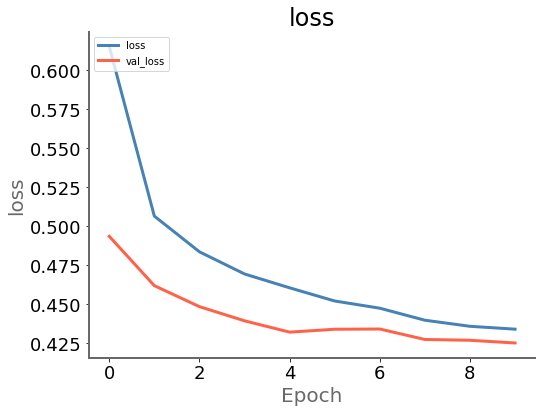

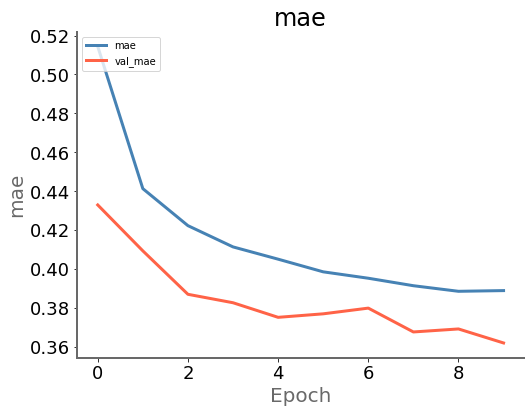

In [10]:
pwk.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='01-history')

## Step 5 - Predict

### 5.1 - Load model

In [11]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')

### 5.2 Make a prediction
A basic prediction, with normalized values (so humanly not very understandable)

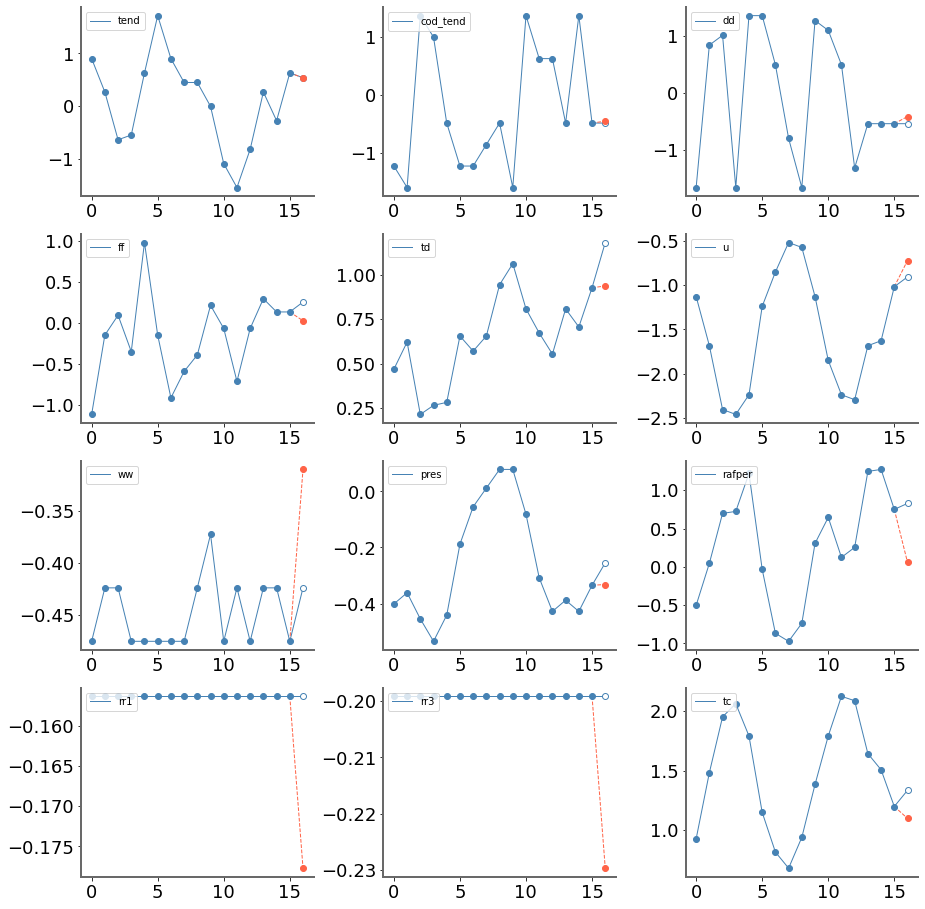

In [12]:
s=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

pred = loaded_model.predict( np.array([sequence]) )

# ---- Show result
pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm')


### 5.3 Real prediction
We are now going to make a true prediction, with an un-normalized result

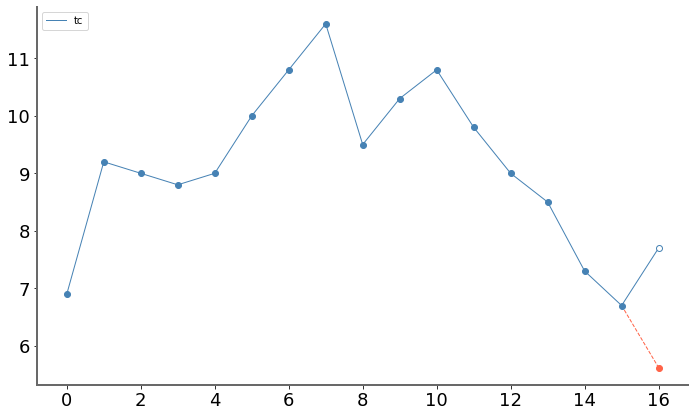

Gap between prediction and reality : 2.08 °C


In [13]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]

# ---- Prediction

pred = loaded_model.predict( np.array([sequence]) )

# ---- De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

# ---- Show it
feat=11

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8, save_as='03-prediction')

delta_deg=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta_deg:.2f} °C')


In [14]:
pwk.end()

End time is : Sunday 07 March 2021, 21:18:01
Duration is : 00:01:58 640ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>